In [2]:
# import libaries
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine
import time
from datetime import date, timedelta
from rl_v2g import CarsharingEnv
import math

# load the database credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


# Application of Car-sharing Simulation Environment 

Choose the timespan for the simulation. The simulation will be executed chronologically, starting from the first day (2019-1-1) and continuing for subsequent days (2019-1-2, 2019-1-3, etc.). If a start date other than 2019-1-1 is selected, the "Start simulation" cell below may need to be modified.

In [3]:
# set simulation period
start_date = date(2019, 1, 1) # inlcusive
end_date = date(2019, 1, 5) # exclusive

# calculate number of days to simulate
nr_iterations = (end_date - start_date).days

# Load data for simulation

### Car-sharing stations

In [4]:
# get station geodata
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")

# create necessary features
stations["x"] = stations.geom.x.values
stations["y"] = stations.geom.y.values

# create spatial index
stations.sindex

# show data structure
#stations.head()

### Vehicle information

In [5]:
# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)

# show data structure
#vehicles.head()

### Reservations

In [6]:
# get daily reservations including pre processing, save daily tables dict for fast data access during simulation
delta = timedelta(days=1)
reservations_dict = {}
start_date_reservations = start_date
while start_date_reservations <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, syscreatedate_time_discrete, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations)
    reservations = pd.read_sql(sql, engine)
    reservations_dict[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta

# show data structure within dict
#reservations_dict[(start_date).strftime('%Y-%m-%d')].head()

### Electicity prices for charging

In [7]:
# get energy costs data
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)
sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
charging_costs = pd.read_sql(sql, engine)

# save daily tables in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict = {}
start_date_electricity = start_date
while start_date_electricity <= end_date:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

# show data structure
#charging_costs.head()

### Secondary energy prices (for V2G/G2V operations)

In [8]:
# get v2g price data
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)

# save daily tables in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict = {}
start_date_v2g = start_date
while start_date_v2g <= end_date:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta
    
# show data structure 
#v2g_prices.head()

# Create environment

The following code creates the simulation enviroment. The list below descripes all simulation settings that can be specified. You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

**planned_bookings:** Boolean, optional<br>
*Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.*

**precomputed_bookings:** Boolean, optional<br>
*Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.*

**location_state:** String, optional<br>
*Three options, by default "binary":
- "station_id":
    - Station number (1000-6000)
    - Reservation number (2x'xxx'xxx) during trip
    - Reservation number (3x'xxx'xxx) during relocation
    - -1 if the car is not available
- "geocoordinates":
    - Coordinates (x, y) of the station in LV95
    - Coordinates far away for cars not at the station (1000000, 0)
- "binary":
    - 0 if the car is not available
    - 1 if the car is at a station*

**normalize_state:** Boolean, optional<br>
*Boolean indicating whether to apply min-max normalization (0-1) to state features, by default False.*

**random_seed_number:** Int, optional<br>
*Used for fixing random components in the environment for reproducible results, by default 122.*

**max_charging_power:** Int, optional<br>
*Maximum charging power supported at the stations, by default 11.*

**soc_initial_low:** Float, optional<br>
*Lower bound (0-1) for initial SOC used for the reset of the environment, by default 0.5 (50%).*

**soc_initial_high:** Float, optional<br>
*Upper bound (0-1) for initial SOC used for the reset of the environment, by default 1.0 (100%).*

**max_distance_car_assignment:** Int, optional<br>
*Maximum search distance in meters for the car-assignment problem, by default 1000.*

**penalty_per_kwh:** Int, optional<br>
*Penalty in CHF/kWh for negative energy difference (total over fleet) between the beginning and ending of the episode, by default 0.0.*

**cancellation_penalty:** Int, optional<br>
*Maximum penalty in CHF for a booking canceled due to not enough charged battery, by default 100.*

**v2g:** Boolean, optional<br>
*Boolean indicating if V2G and G2V events take place, by default True.*

**v2g_demand_event_min:** Int, optional<br>
*Minimum energy demand during a V2G event in kWh per time step (dt), by default 500.*

**v2g_demand_event_max:** Int, optional<br>
*Maximum energy demand during a V2G event in kWh per time step (dt), by default 500.*

**v2g_max_duration:** Float, optional<br>
*Maximum duration of a V2G charging or discharging event in hours, by default 2.0.*

**v2g_penalty:** Int, optional<br>
*Penalty in CHF if the agent charges/discharges less energy than required during a V2G/G2V event, by default 499.*

**v2g_penalty_quantity_dependent:** Boolean, optional<br>
*Whether the v2g_penalty is constant or dependent on the difference between required and delivered energy, by default False.*

**v2g_probability_charging_event:** Float, optional<br>
*Probability that a charging event will take place around noon, by default 0.5 (50%).*

**v2g_probability_discharging_event:** float, optional<br>
*Probability that a discharging event will take place in the morning or evening, by default 0.5 (50%).*

**v2g_morning_time_period:** List, optional<br>
*Time period must end before noon and should not overlap with v2g_noon_time_period and v2g_evening_time_period. List containing:
- First possible time (hours) for starting a V2G discharging event in the morning, by default 6.0 (6 AM).
- Last possible time (hours) for starting a V2G discharging event in the morning, by default 9.0 (9 AM).
- Last possible timestamp for V2G discharging operation, by default 11.0 (11:00 AM).*

**v2g_noon_time_period:** List, optional<br>
*Time period should not overlap with v2g_morning_time_period and v2g_evening_time_period. List containing:
- First possible time (hours) for starting a G2V charging event at noon, by default 11.25 (11:25 AM).
- Last possible time (hours) for starting a G2V charging event at noon, by default 14.0 (2:00 PM).
- Last possible timestamp for G2V charging operation, by default 15.75 (3:45 PM).*

**v2g_evening_time_period:** list, optional<br>
*Time period must start after noon and should not overlap with v2g_morning_time_period and v2g_noon_time_period. List containing:
- First possible time (hours) for starting a V2G discharging event in the evening, by default 16.0 (4:00 PM).
- Last possible time (hours) for starting a V2G discharging event in the evening, by default 20.0 (8:00 PM).
- Last possible timestamp for V2G charging operation, by default 22.0 (10:00 PM).*

**plot_state_histogram:** Boolean, optional<br>
*Plot the current state of the environment as a histogram or not, by default False.*

**plot_state_animation:** Boolean, optional<br>
*Plot the current state of the environment as an animation for each car or not, by default False.*

In [9]:
param_dict = {
    "planned_bookings": True,
    "precomputed_bookings": True,
    "location_state": "station_id",
    "normalize_state": False,
    "random_seed_number": 122,
    "max_charging_power": 11,
    "soc_initial_low": 0.5,
    "soc_initial_high": 1.0,
    "max_distance_car_assignment": 1000,
    "penalty_per_kwh": 0.0,
    "cancellation_penalty": 100,
    "v2g": True,
    "v2g_demand_event_min": 500,
    "v2g_demand_event_max": 500,
    "v2g_max_duration": 2.0,
    "v2g_penalty": 499,
    "v2g_penalty_quantity_dependent": False,
    "v2g_probability_charging_event": 0.5,
    "v2g_probability_discharging_event": 0.5,
    "v2g_morning_time_period": [6.0, 9.0, 11.00],
    "v2g_noon_time_period": [11.25, 14.0, 15.75],
    "v2g_evening_time_period": [16.0, 20.0, 22.0],
    "plot_state_histogram": False,
    "plot_state_animation": False
}


# Implement your charging strategy

In [10]:
def your_v2g_strategy(state, nr_vehicles):
    # state has length of nr_vehicles * 4 + 2 with the default setting
        
    # get current locations of vehicles (station number integer between 1000 and 5000, reservation number integer between 20000000 and 40000000, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (float between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
    
    # get planned reservations of vehicles (number of timesteps from the current simulation time until the start of the reservation in 15 minutes timesteps, integer between 0 and 672)
    planned_reservations = state[nr_vehicles * 2:nr_vehicles * 3]
    
    # get durations of planned reservations of vehicles (duration in number of 15 minutes timesteps between 0 and 672)
    planned_reservations = state[nr_vehicles * 3:nr_vehicles * 4]
        
    # check if V2G event will take place and get demand in the next timestep (0 = no V2G event, positive integer between 500 and 1000 = discharging event, negative integer between 500 and 1000 = charging event)
    v2g_event = state[nr_vehicles * 4:nr_vehicles * 4 + 1]
    
    # get current simulation time, integer between 0 and 55392
    current_time = state[nr_vehicles * 4 + 1:]
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    # dummy examples:
    # charge all vehicles
    action = np.ones(nr_vehicles)
    
    # discharge all vehicles
    # action = np.full(nr_vehicles, 2)
    
    # do nothing
    # action = np.zeros(nr_vehicles)

    # send action to enviroment
    return action


# Start long-term simulation

The following code simulates the car-sharing system using your charging strategy over the chosen time period. The following methods of the CarsharingEnv object could be helpful for your specific implementation of the simulation:

### load_new_data():
Loads data to environment for the simulation of a new day.

***daily_data:*** Pandas DataFrame<br>
*Contains the historical car-sharing trips over the current day.*

***reservations:*** Pandas DataFrame<br>
*Includes the features "reservation_no", "start_station_no", "syscreatedate_time_discrete", "vehicle_no", "drive_firststart_time_discrete", "drive_lastend_time_discrete", "reservationfrom_time_discrete", "revenue_distance", "revenue_duration", "revenue_distance", "drive_km", "drive_duration", "required_soc", and "reservation_duration" for each reservation.*

***electricity_price:*** Numpy ndarray<br>
*Contains electricity prices for each discrete timestamp of one day.*

***timesteps_since_start:*** Int<br>
*Timestamp since the start of the simulation (t=0) before the current day.*

***v2g_price:*** Numpy ndarray, optional<br>
*Numpy array of legngth self.episode_len containing prices in CHF per kwh, by default None.*

***planned_reservations:*** Pandas DataFrame, optional<br>
*Timestamps of next planned reservations for each car. Required if planned_bookings is True. By default None.*

***planned_durations:*** Pandas DataFrame, optional<br>
*Durations of next planned reservations for each car. Required if planned_bookings is True. By default None.*

### reset():
Reset environment to beginning of new episode. Is usually called after load_new_data().


### next_day():
Same input as the reset method, but without reseting the environment. Initializes a new day in the simulation.


### episode_summary_statistics(): 
Plot episode summary statistics.

***nr_ticks:*** Int<br>
*Number of xticks in the plot. Usually chosen equal to the number of simulated days.* 


### daily_summary_statistics(): 
Plots summary statistics of last simulated day.


Start the simulation by running the following cell:


Total Episode Time:  0.538898229598999



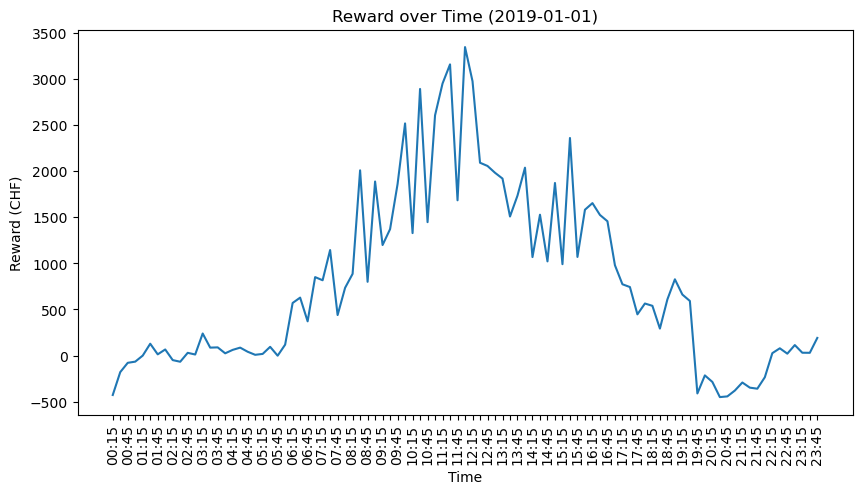

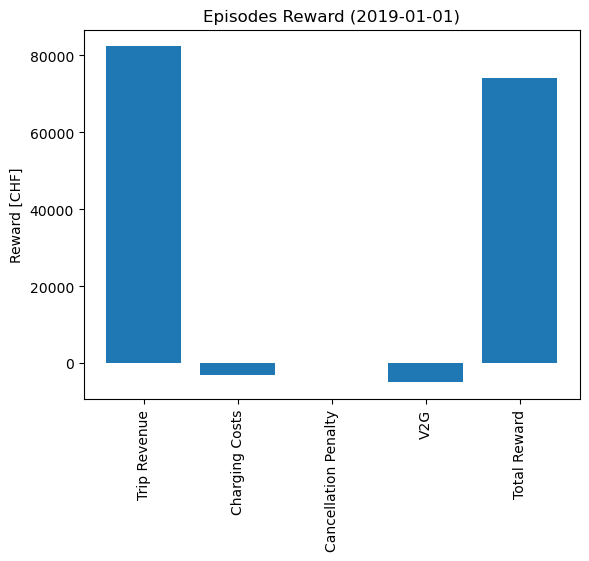

Total reward 2019-01-01:
74265.93785585415

Total Episode Time:  0.7566344738006592



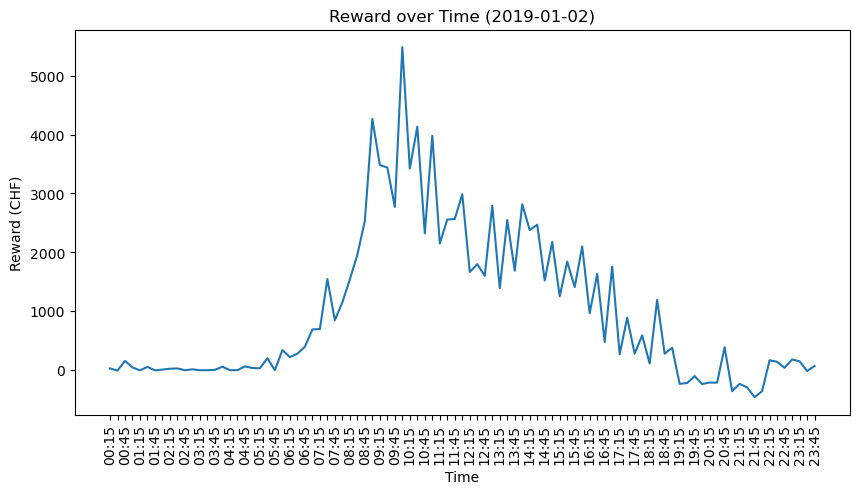

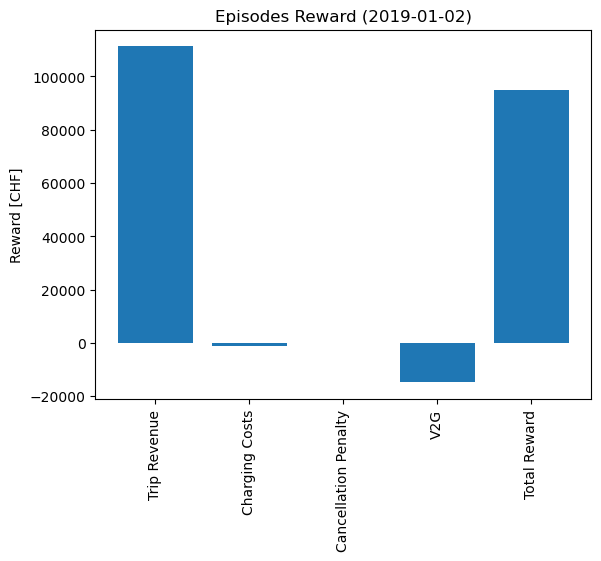

Total reward 2019-01-02:
94998.60447453086

Total Episode Time:  0.8465509414672852



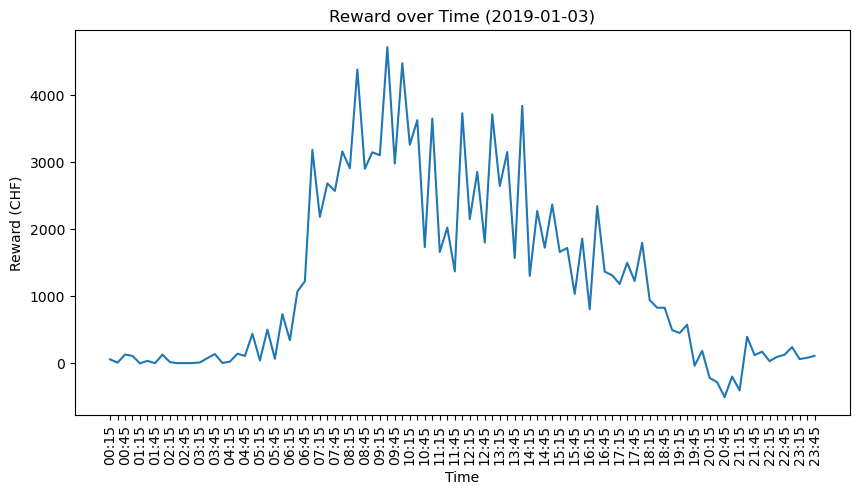

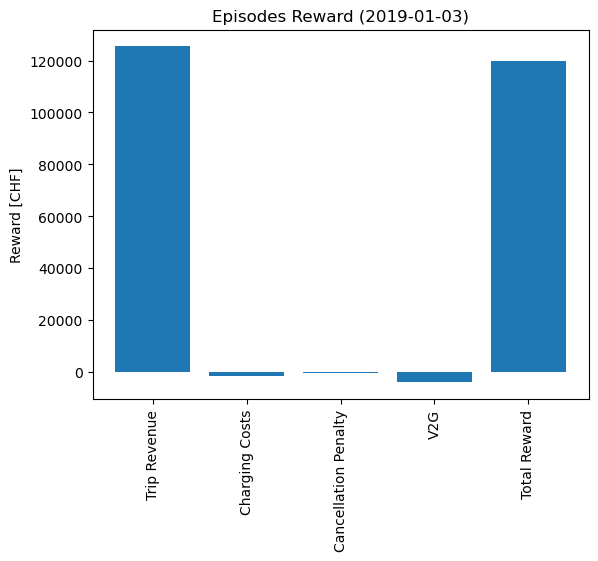

Total reward 2019-01-03:
119814.27011905386

Total Episode Time:  0.983098030090332



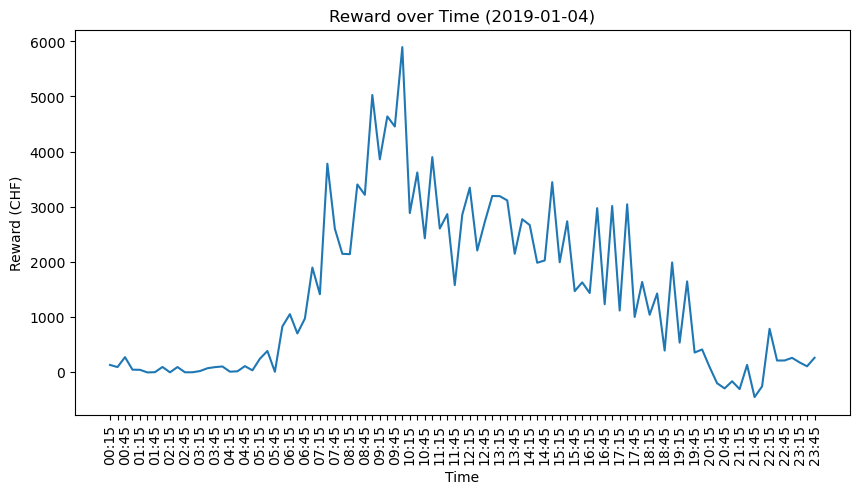

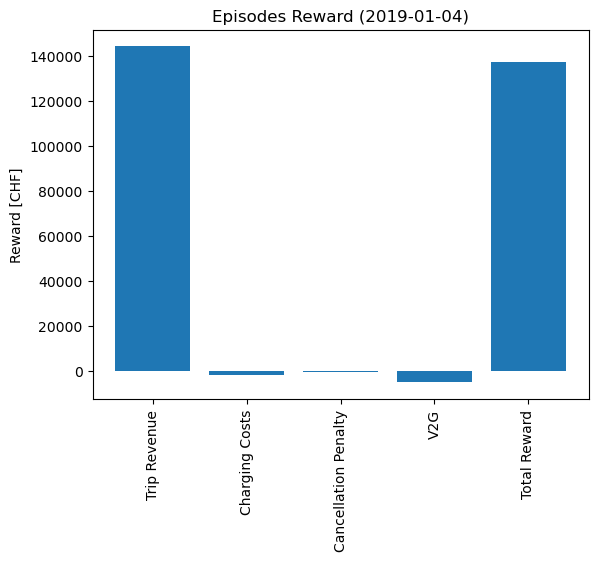

Total reward 2019-01-04:
137054.7641640253


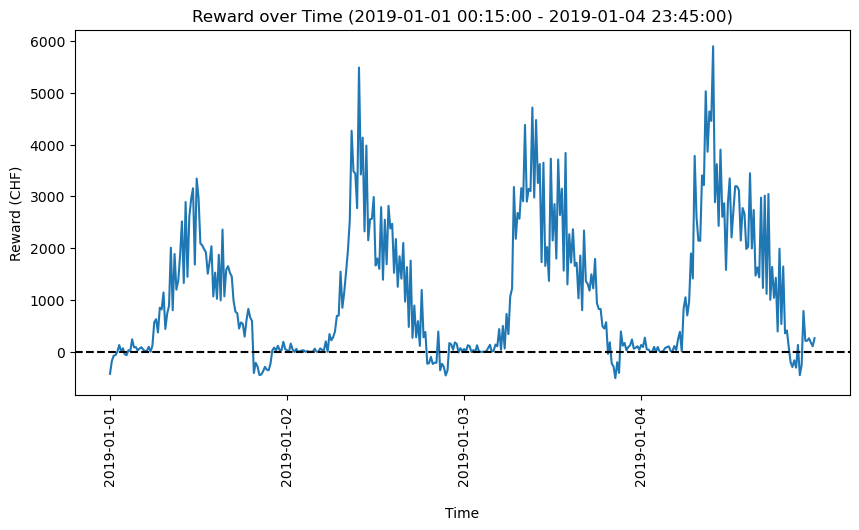

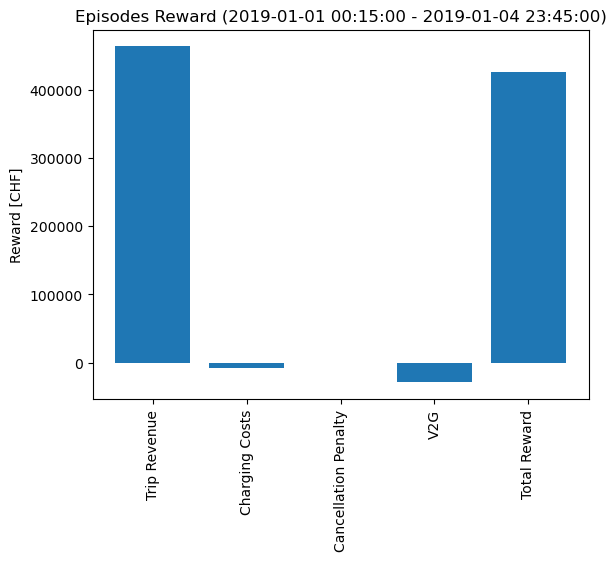

Total reward (2019-01-01 00:15:00 - 2019-01-04 23:45:00):
426232.91811773466


In [11]:
# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length possible with available data
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    # load discrete planned reservation table
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    # load discrete planned reservation duration table
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # measure calculation time of episode
        start = time.time()
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        # reset environment at beginnning of simulation
        if count == 0:
            param_dict["stations"] = stations
            param_dict["vehicle_information"] = vehicles
            param_dict["daily_data"] = daily_data
            param_dict["reservations"] = reservations
            param_dict["electricity_price"] = electricity_price
            param_dict["timesteps_since_start"] = timesteps_since_start
            param_dict["planned_reservations"] = planned_reservations_day
            param_dict["planned_durations"] = planned_durations_day
            param_dict["v2g_price"] = v2g_price
            env = CarsharingEnv(**param_dict)
            s = env.reset()
            
        # beginn new day without reseting environemnt 
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            # print reward at time step
            #print("Reward in this step:", rew, " time: ", env.t)
            
            counter +=1
        
        # measure time needed for simulation of day
        end = time.time()
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        
        # plot summary statistics of episode (day)
        env.daily_summary_statistics()
        
        # plot summary statistic over full simulation period
        if count == nr_iterations - 1:
            env.episode_summary_statistics(nr_iterations)
        
        # count number of simulated days
        count += 1

# Animation of simulaton

We can set the parameter ***plot_state_animation = True*** for getting an animation of the vehicels state at each timestep. Each pixel represents one vehicle of the car-sharing system. On a color scale blue-yellow, we can read the current SOC of each car. Grey vehicles are currently not available in the system (not yet implemented or other reasons). Red pixels refer to cars that are currently serving a booking.

In [12]:
param_dict["plot_state_animation"] = True

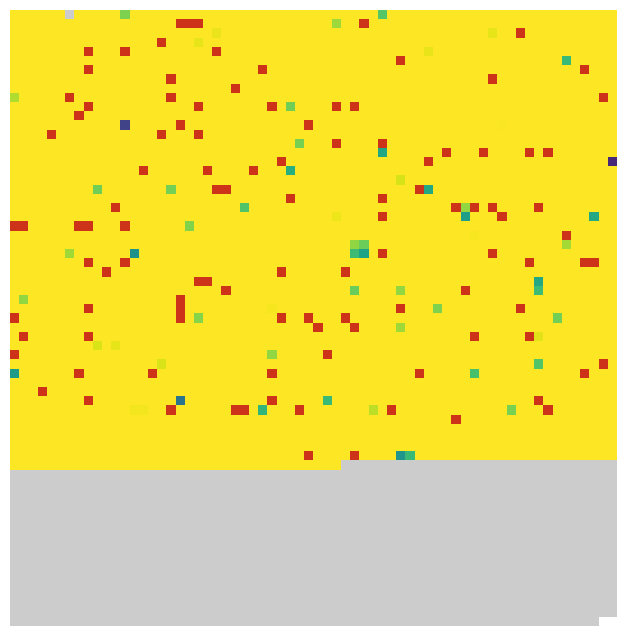

Reward in this step: 191.90650623913712  time:  95

Total Episode Time:  32.77061629295349



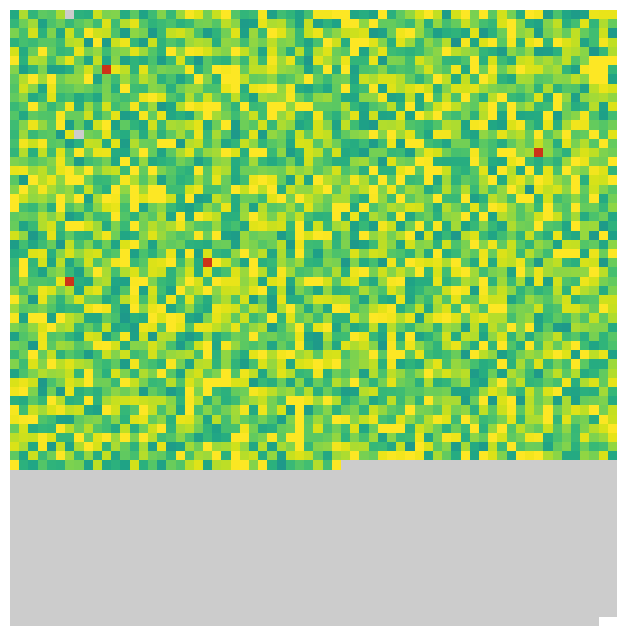

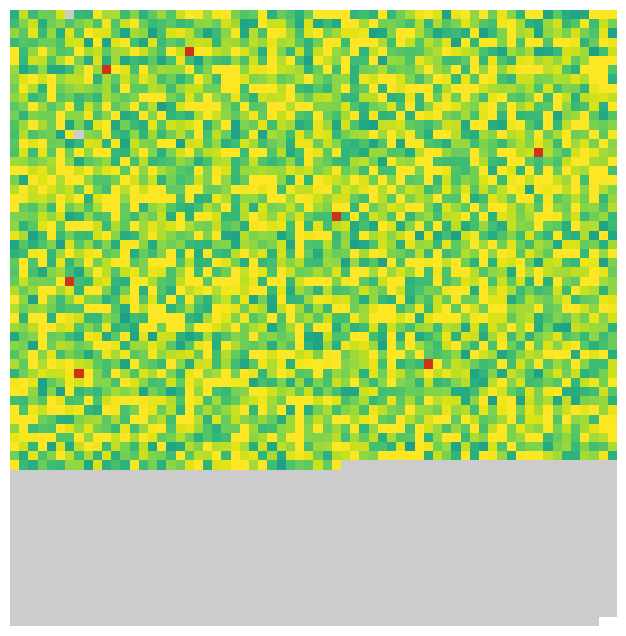

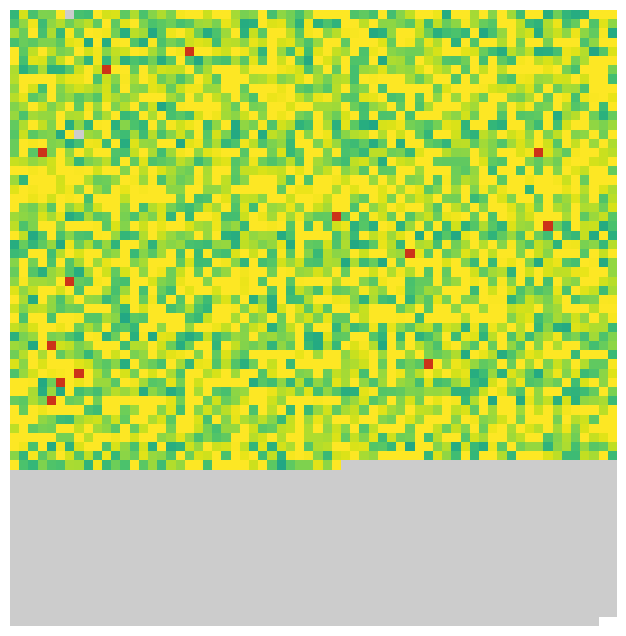

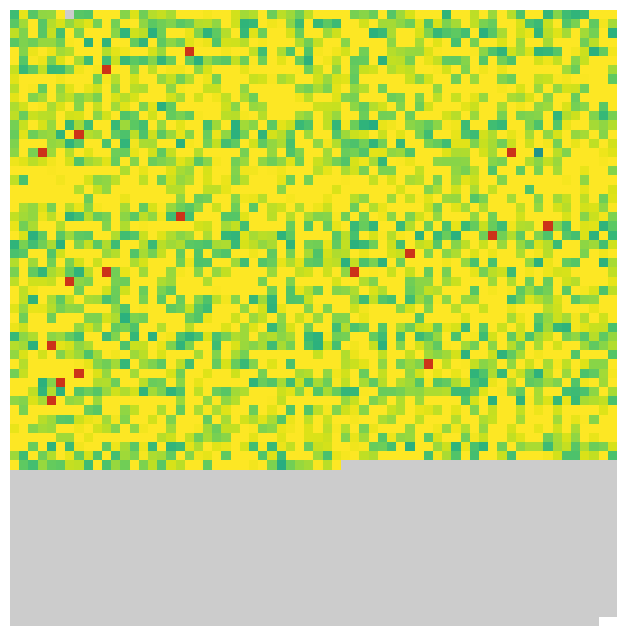

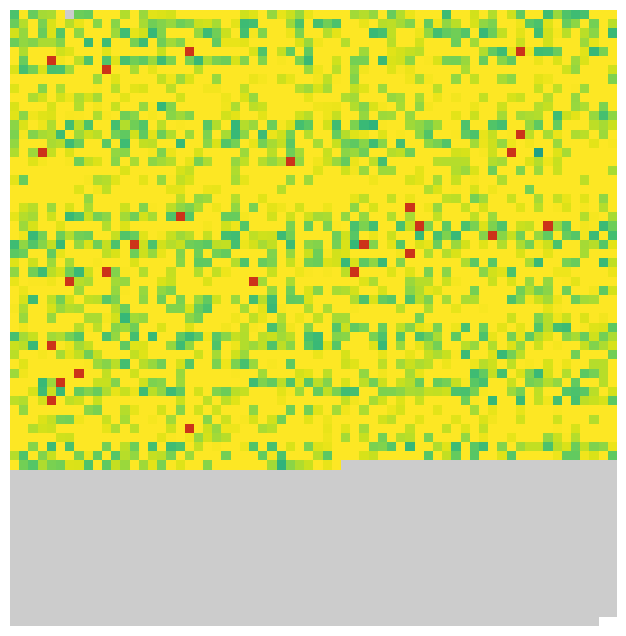

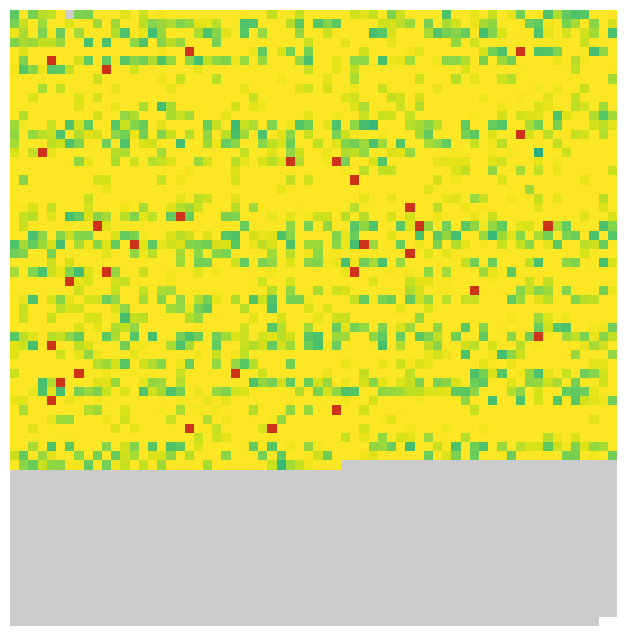

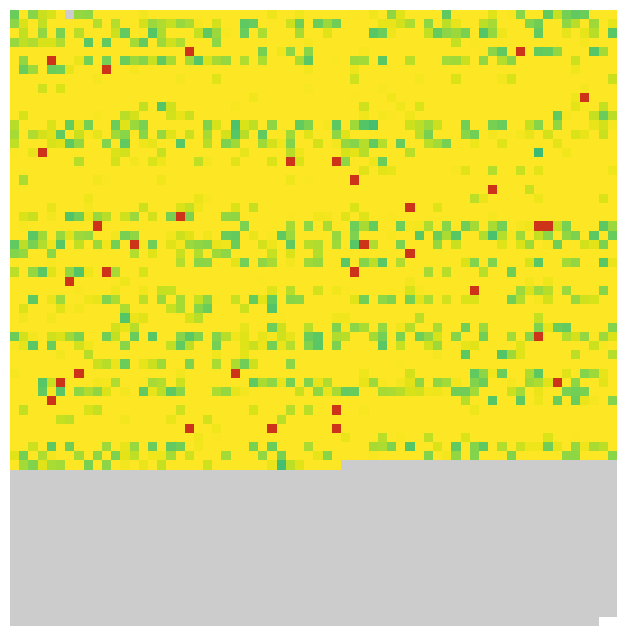

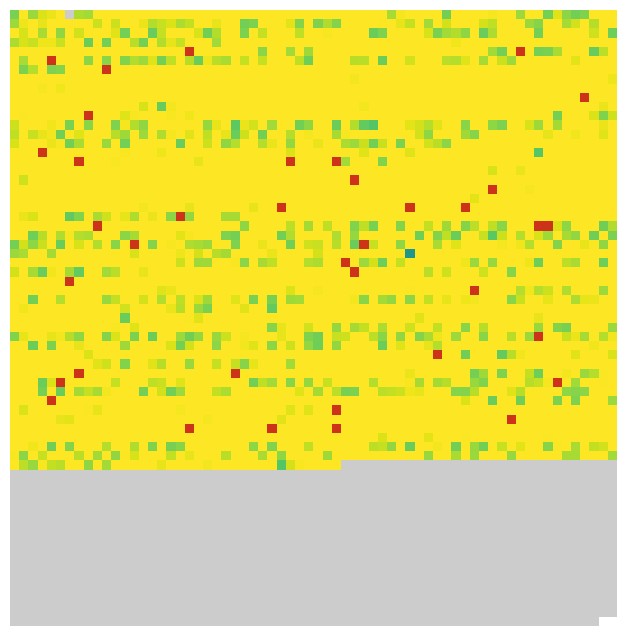

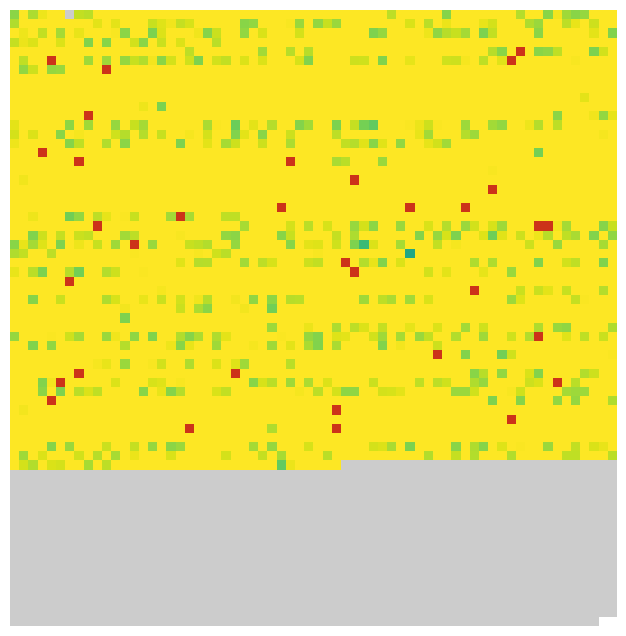

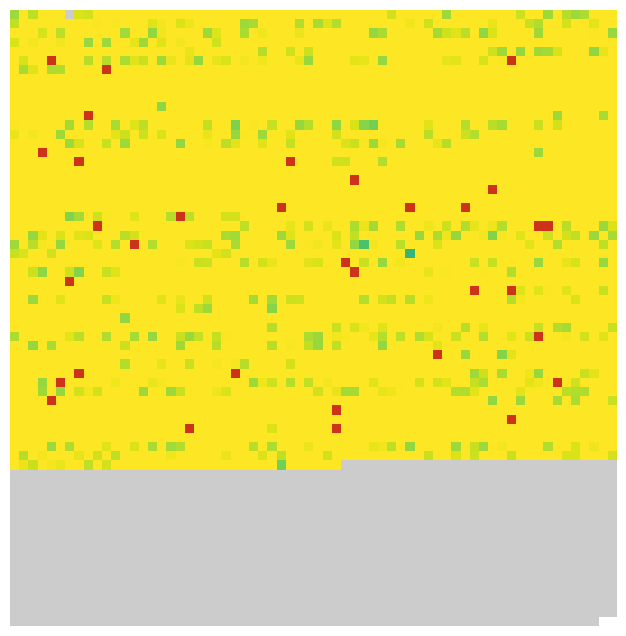

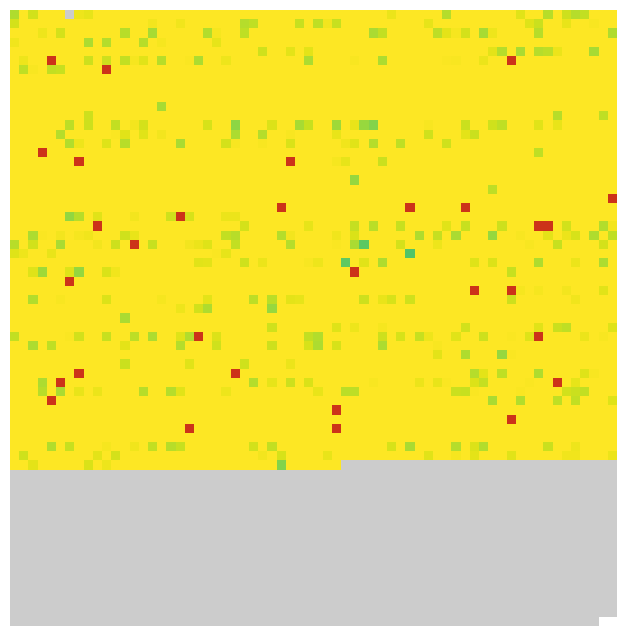

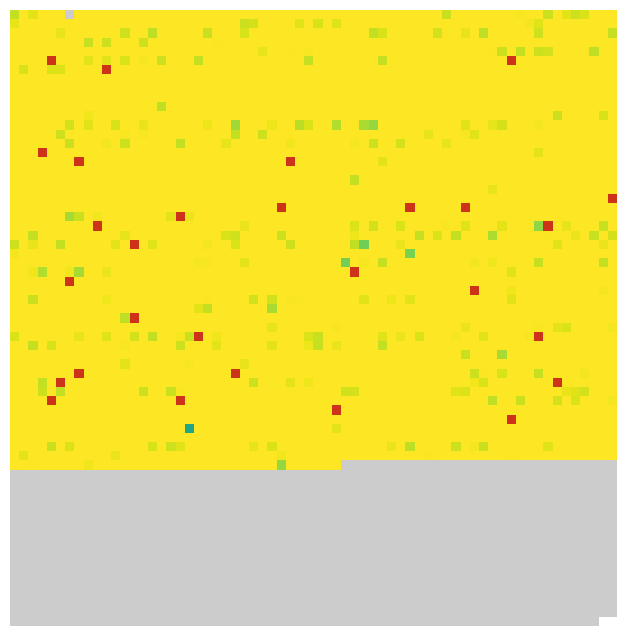

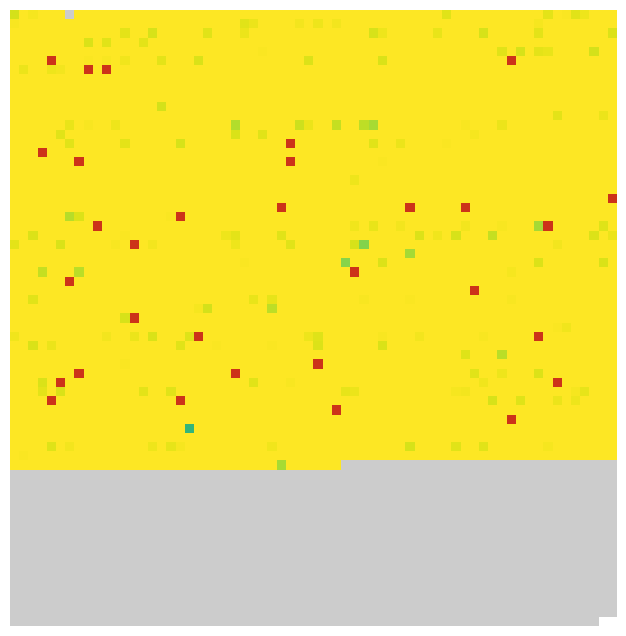

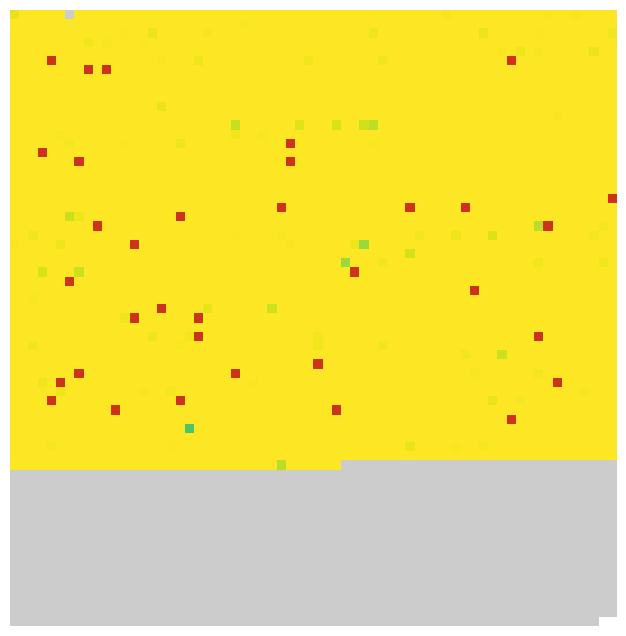

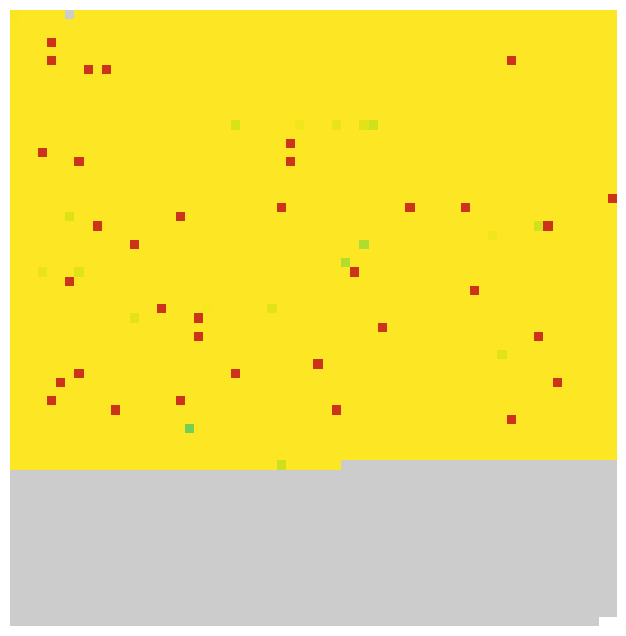

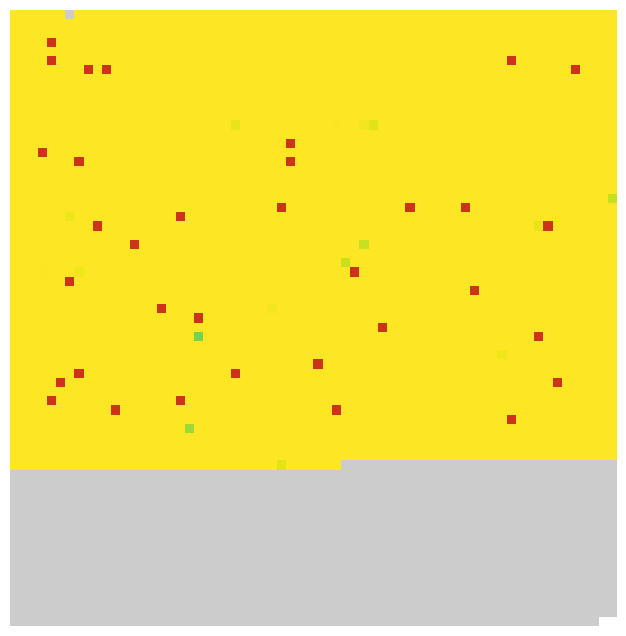

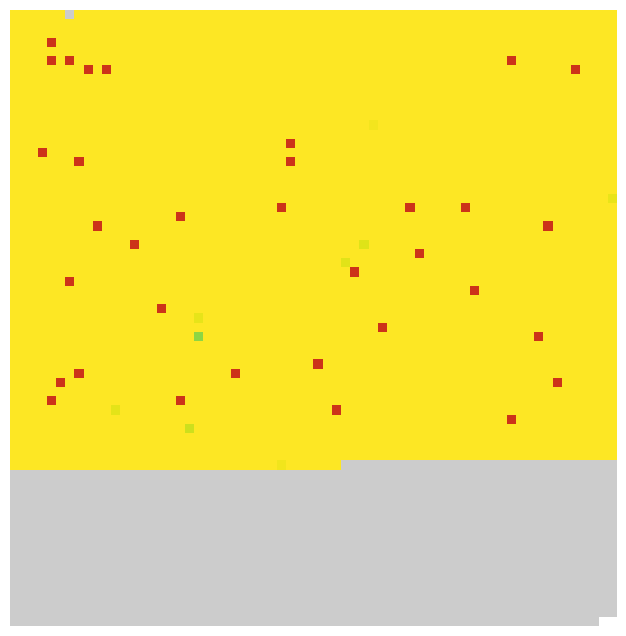

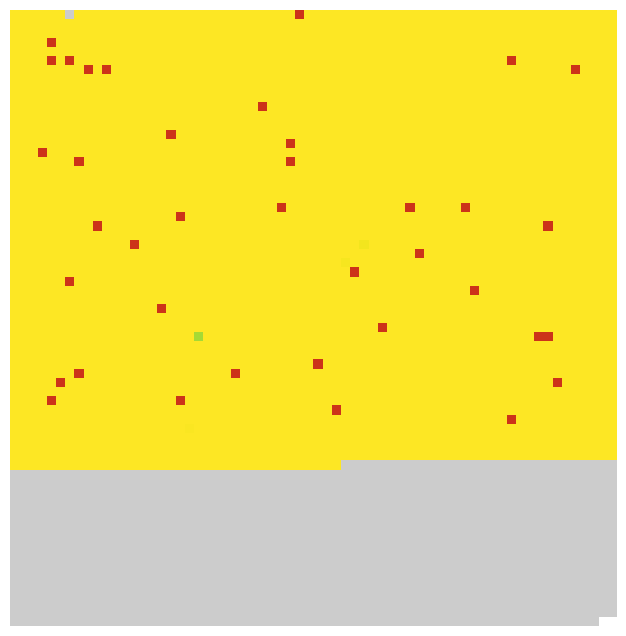

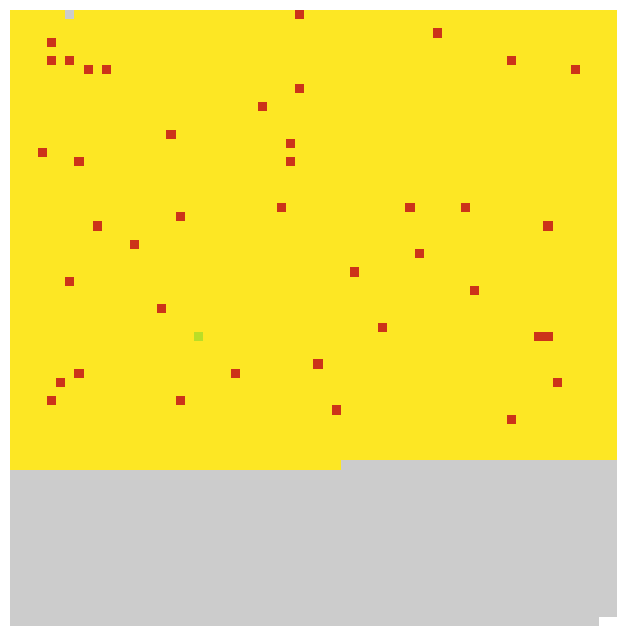

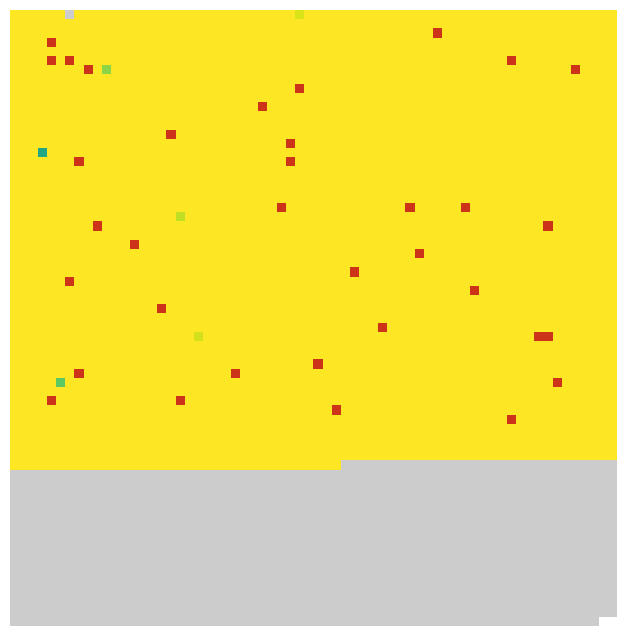

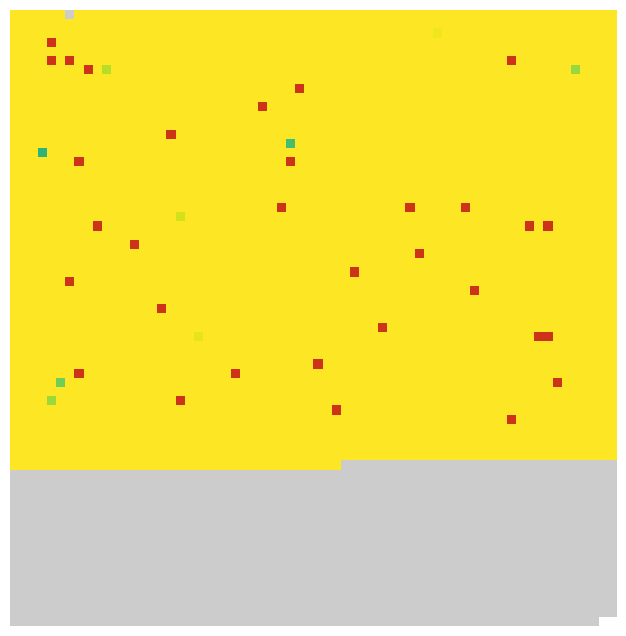

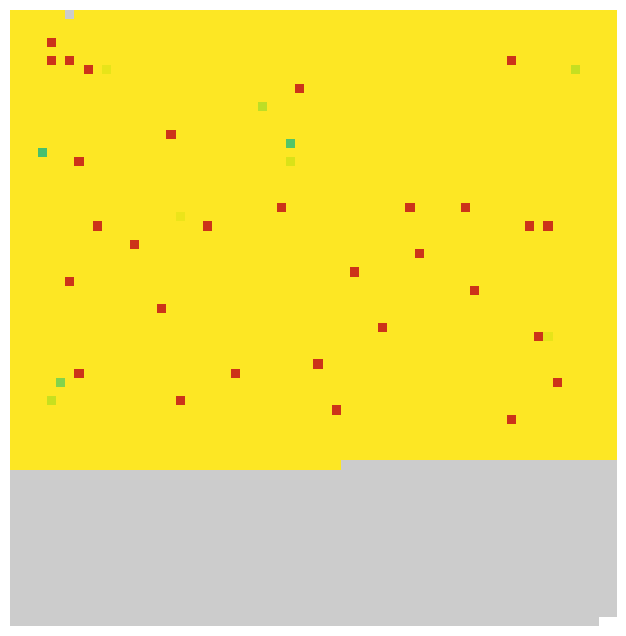

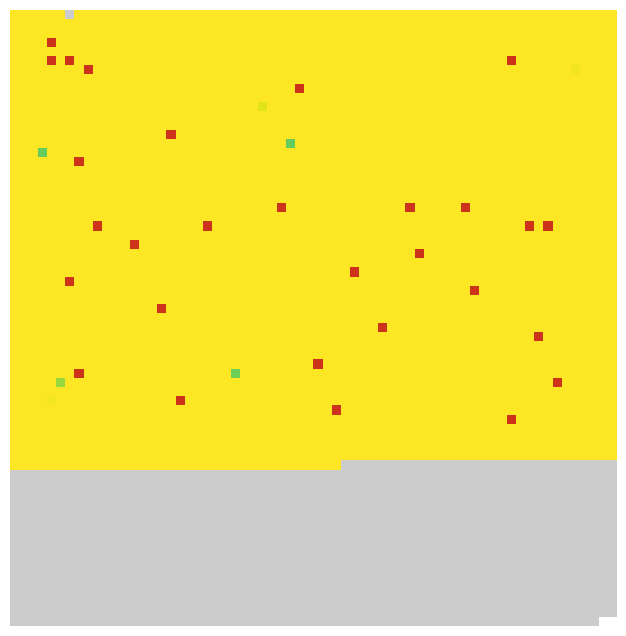

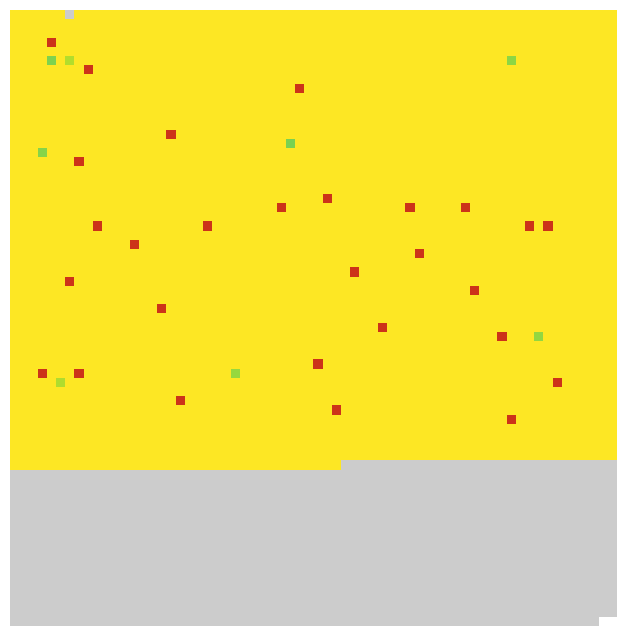

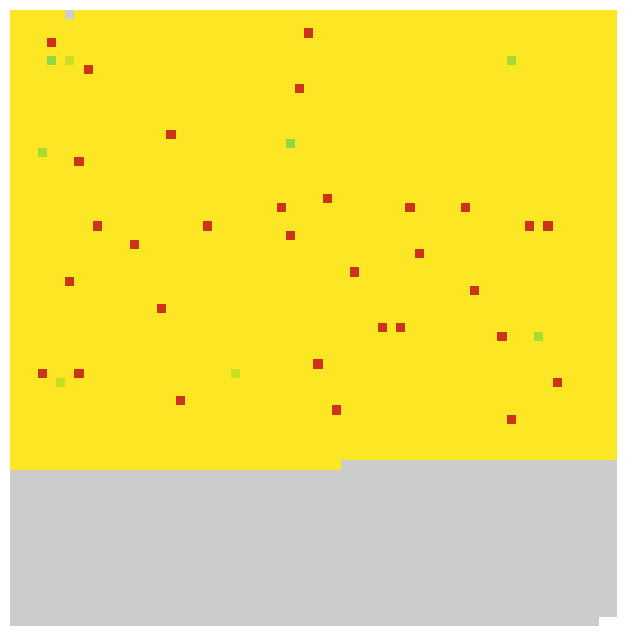

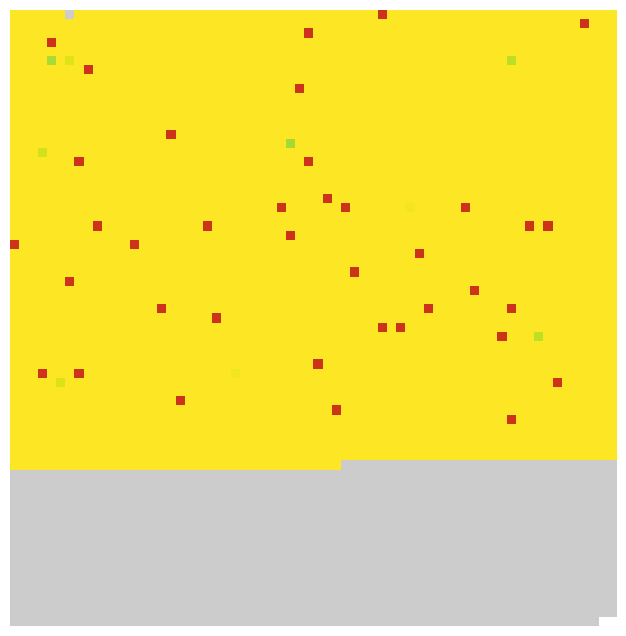

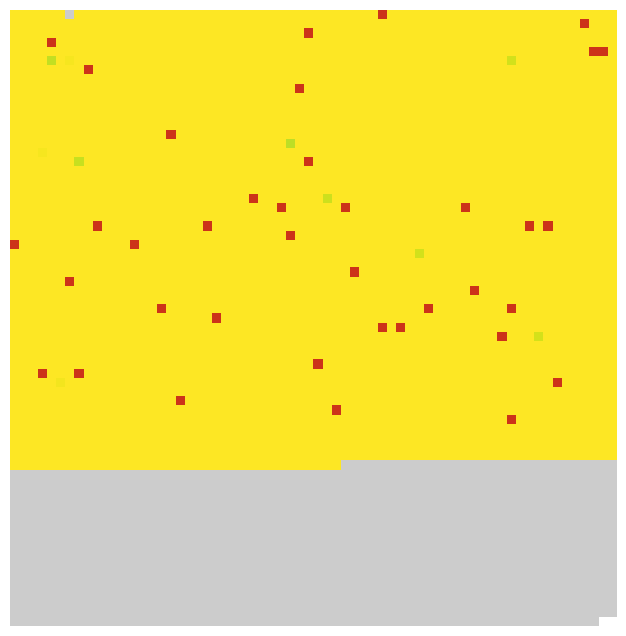

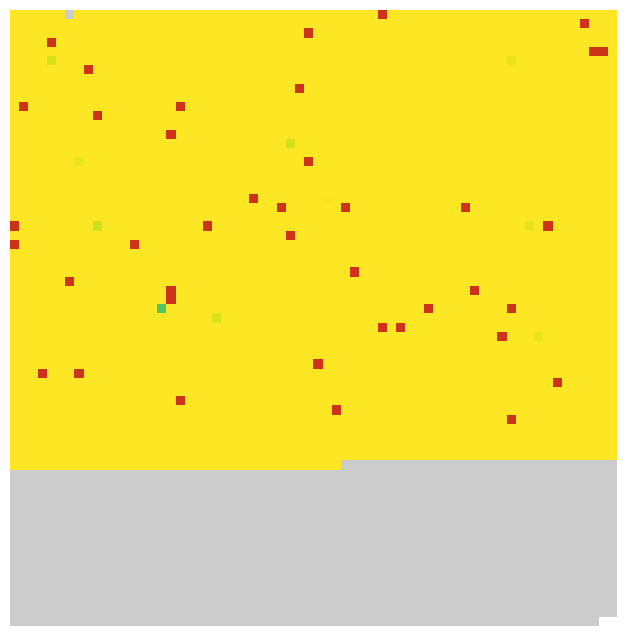

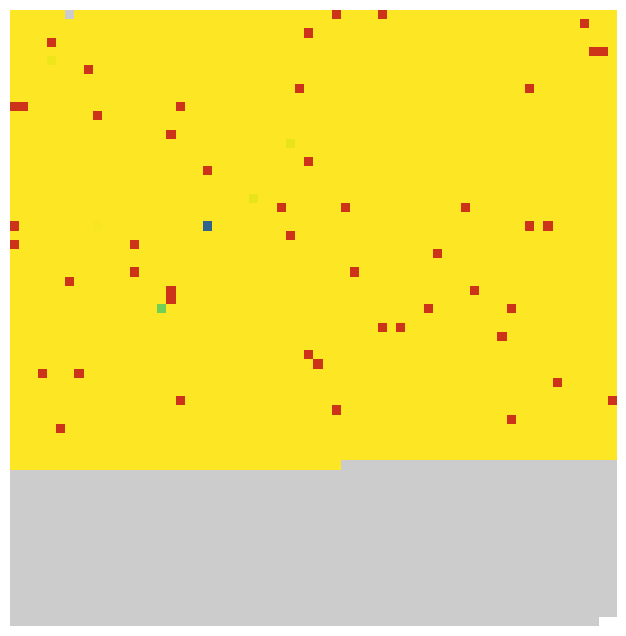

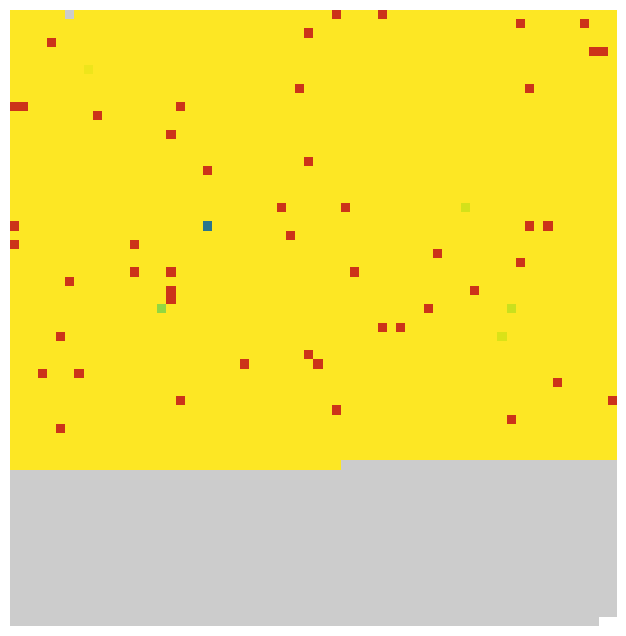

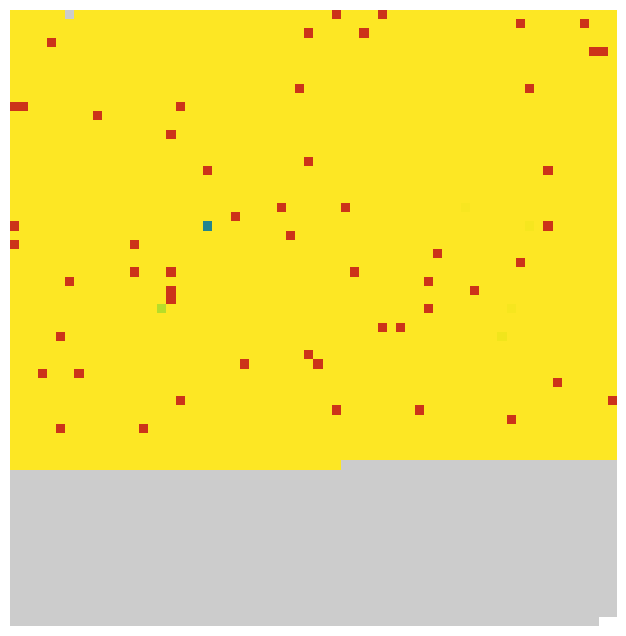

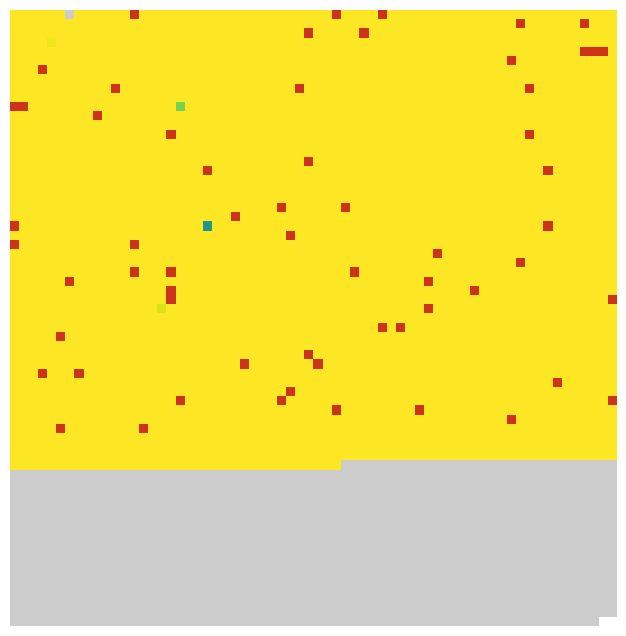

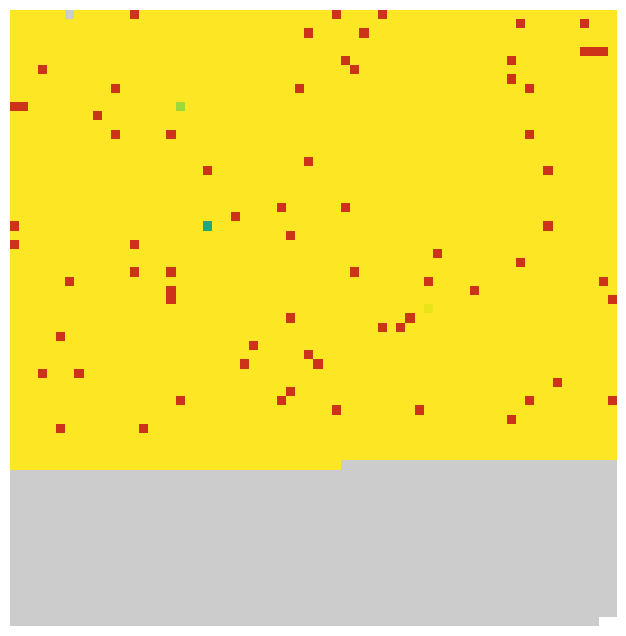

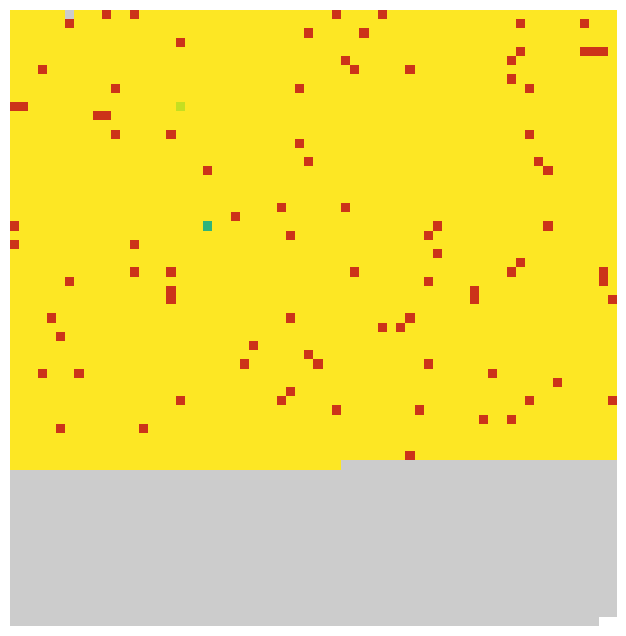

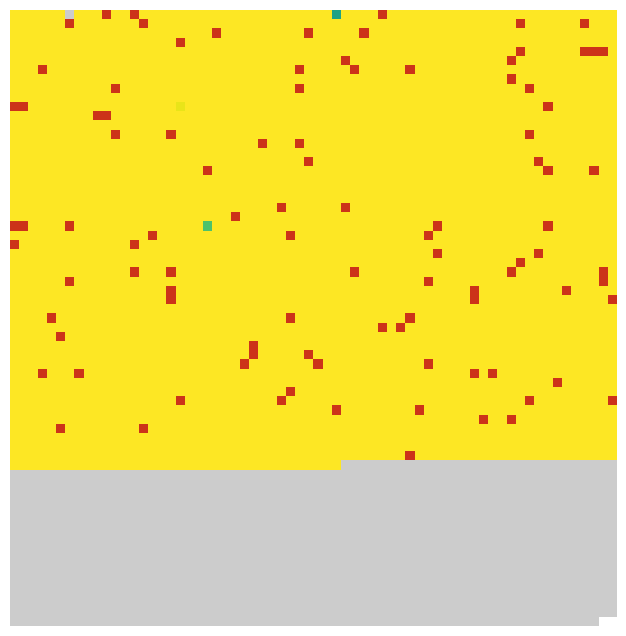

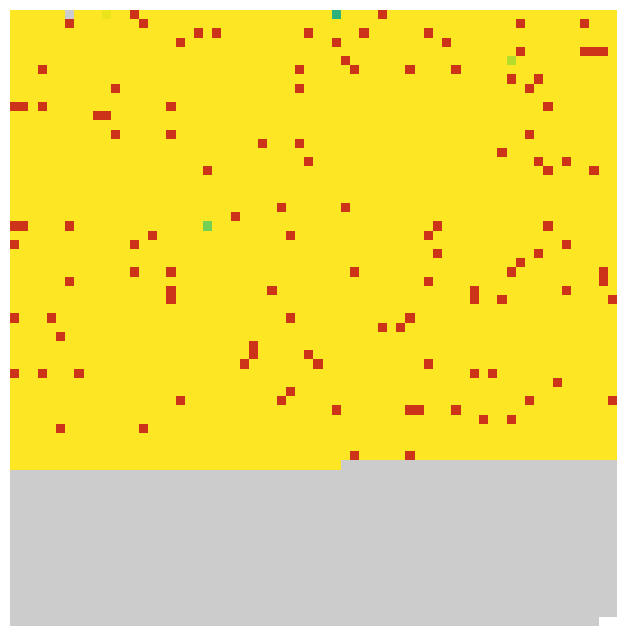

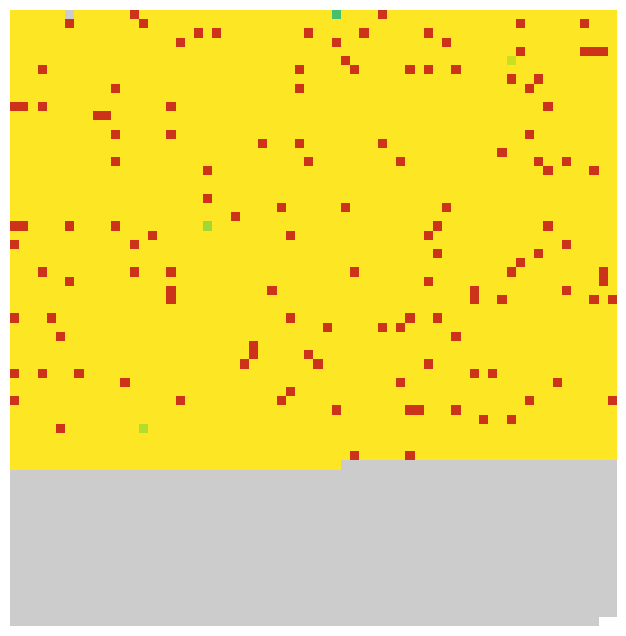

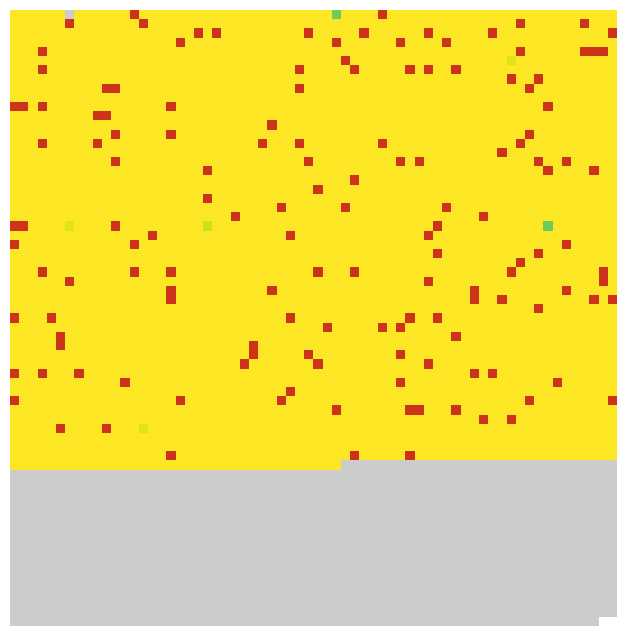

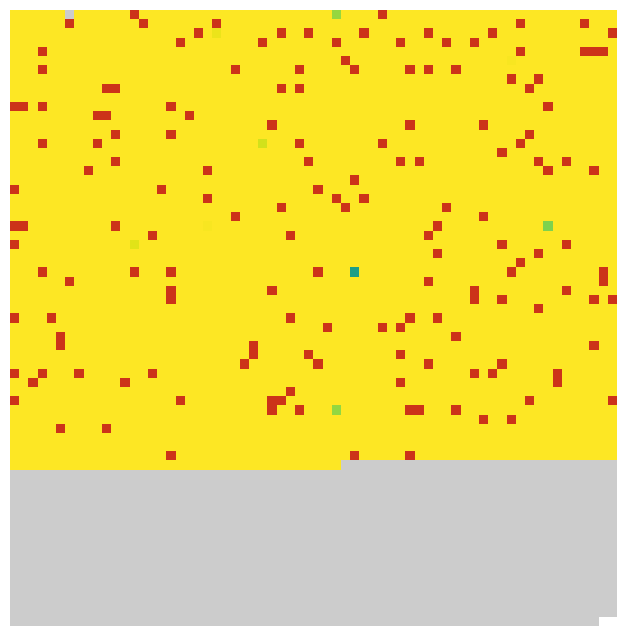

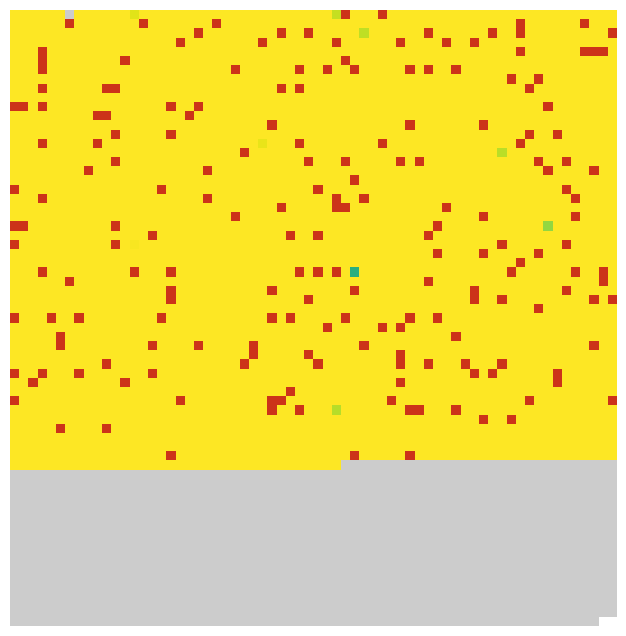

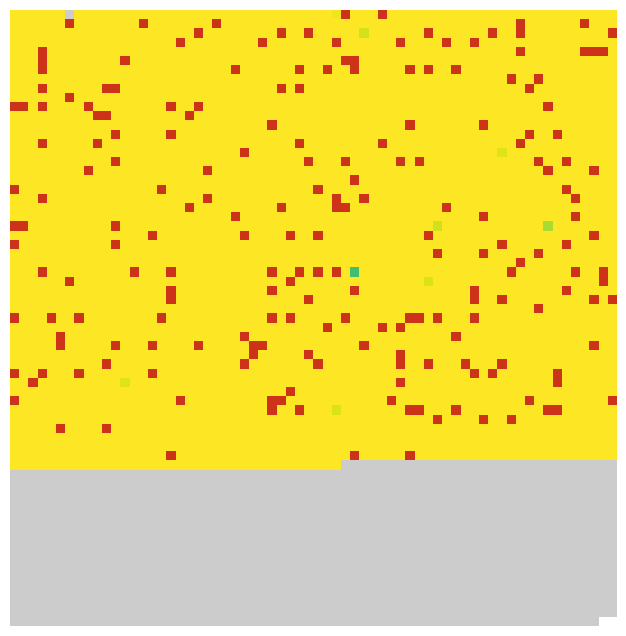

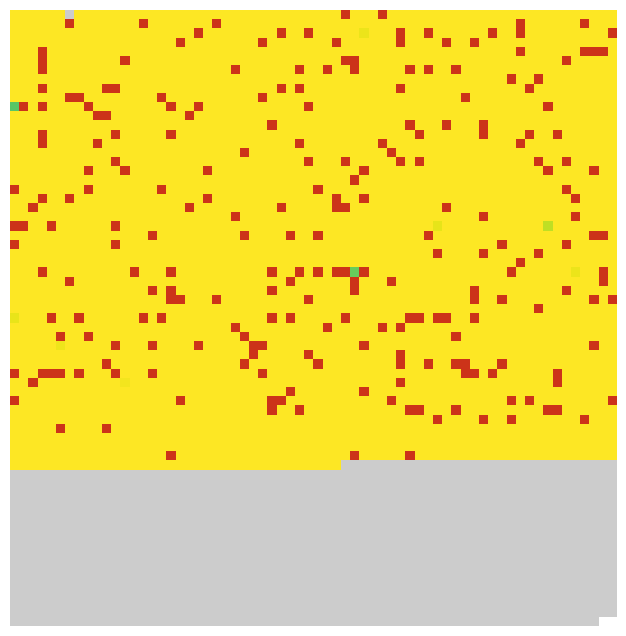

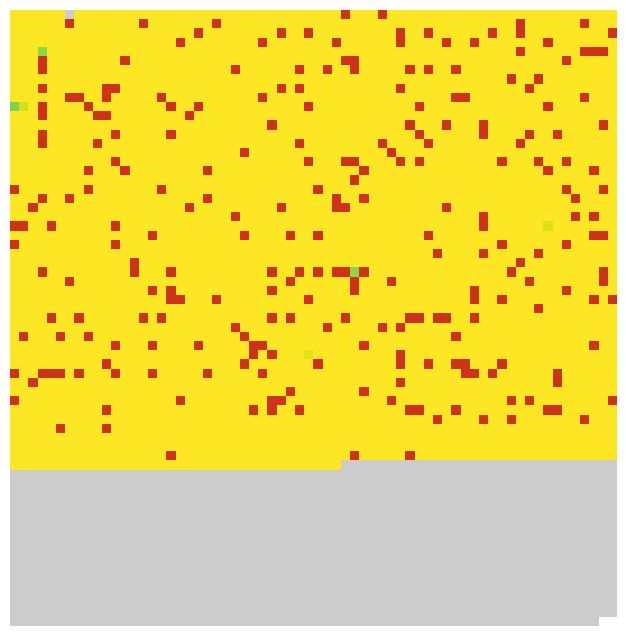

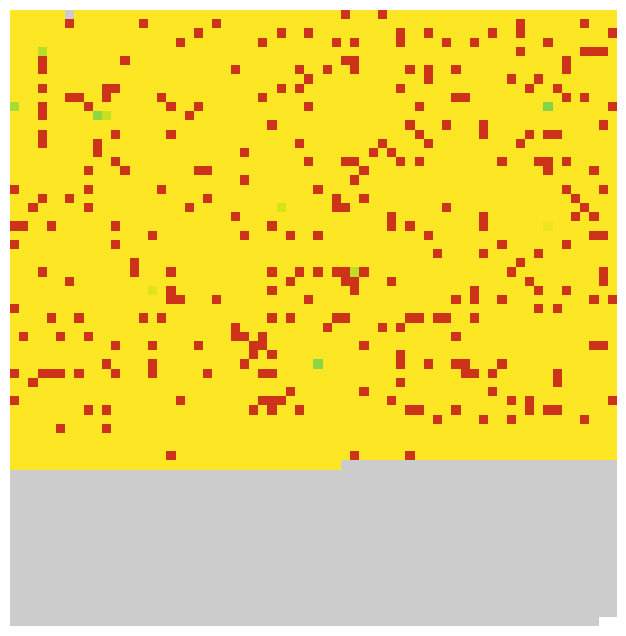

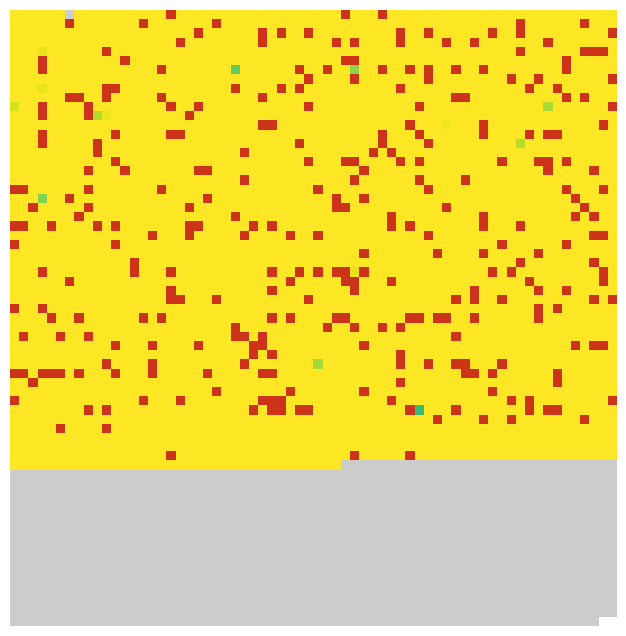

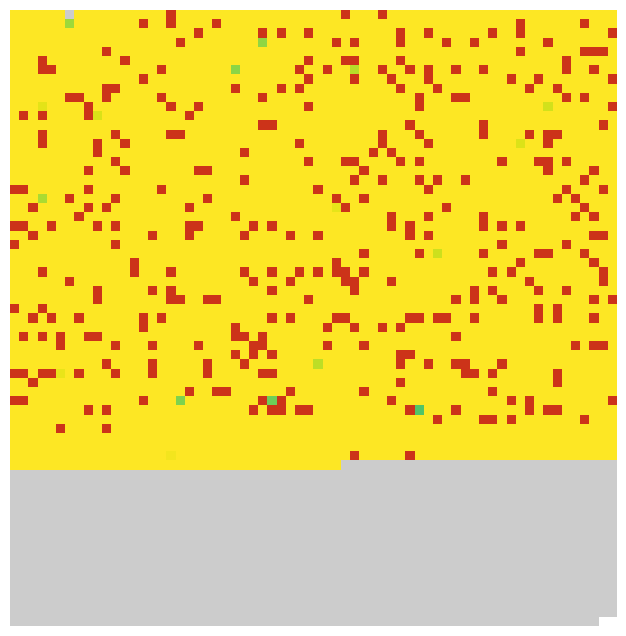

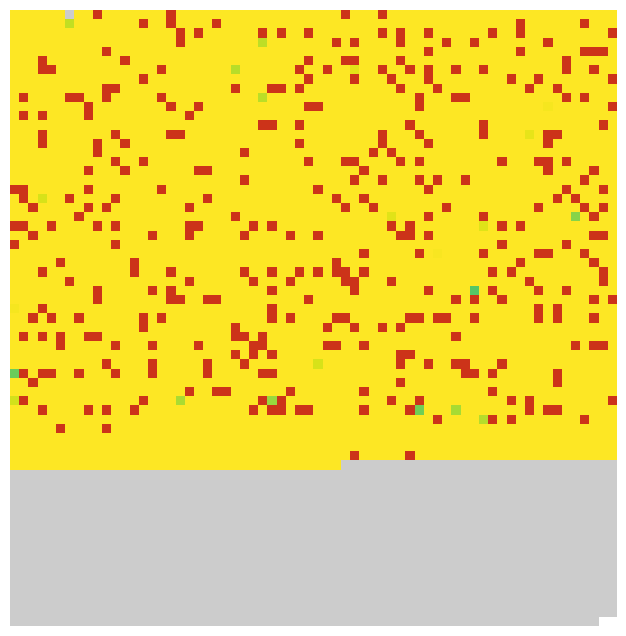

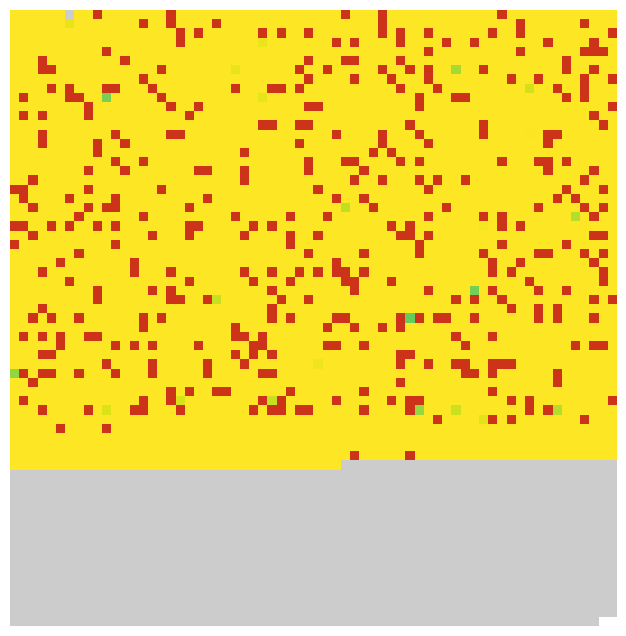

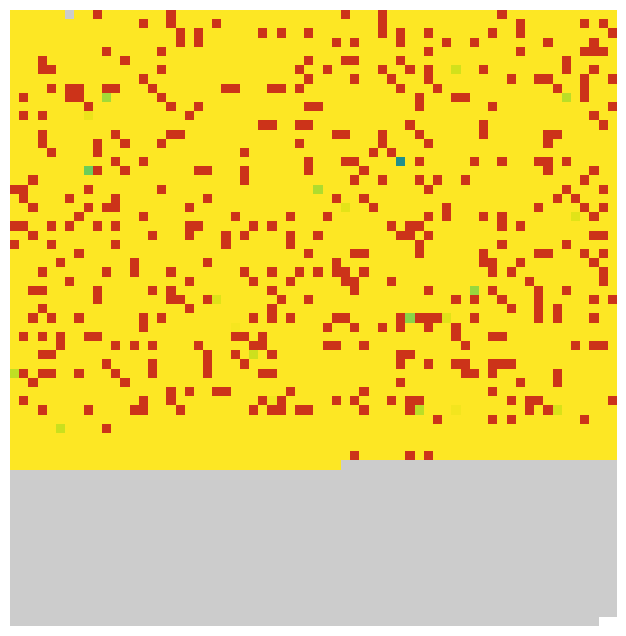

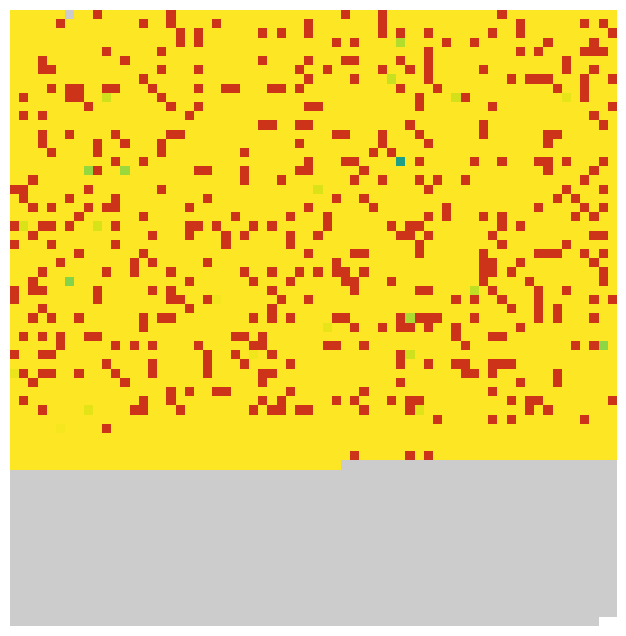

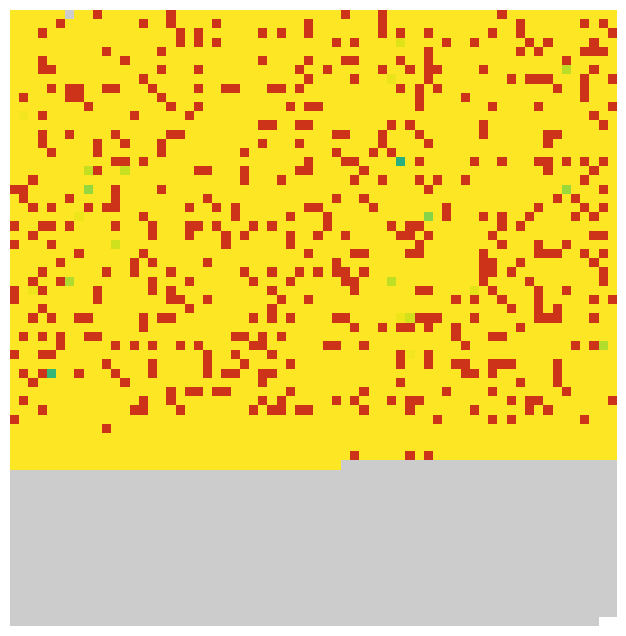

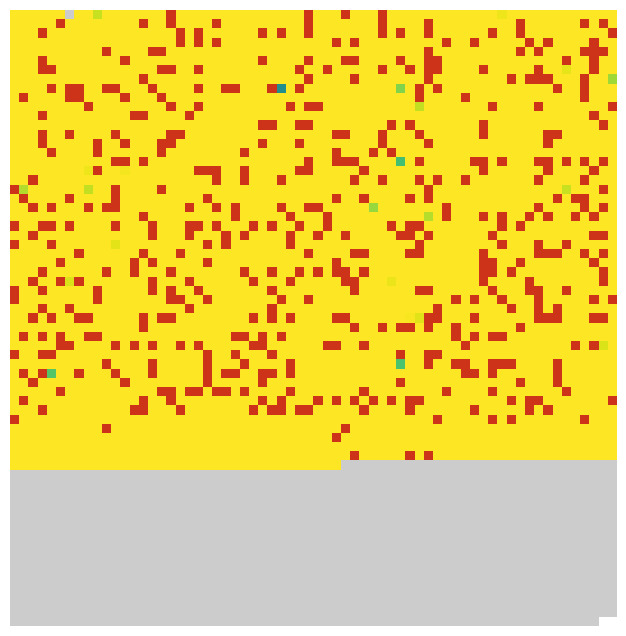

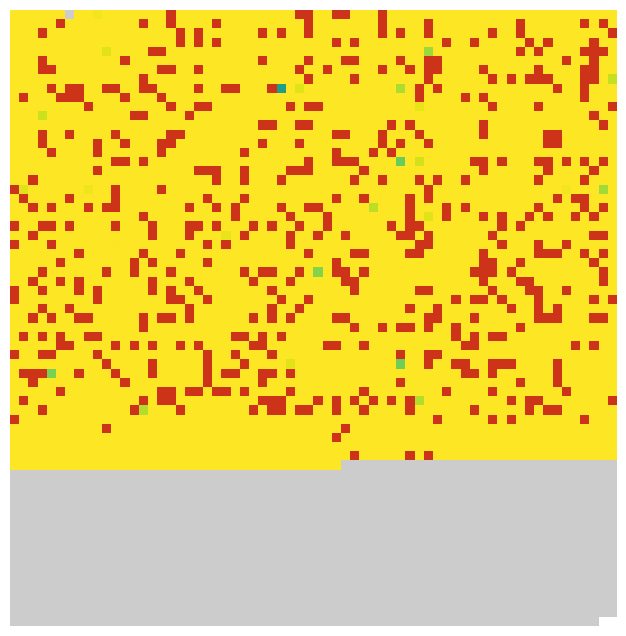

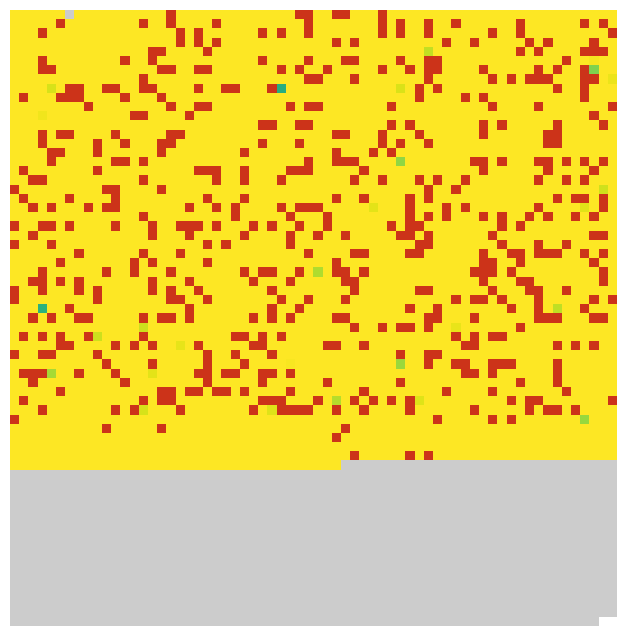

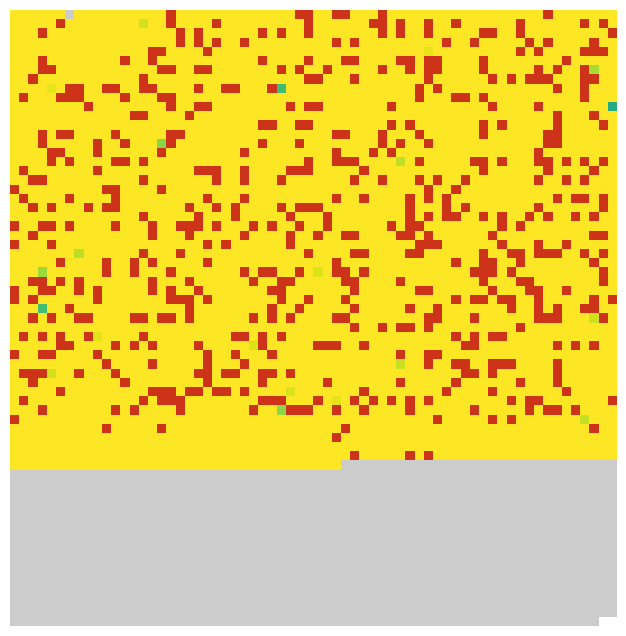

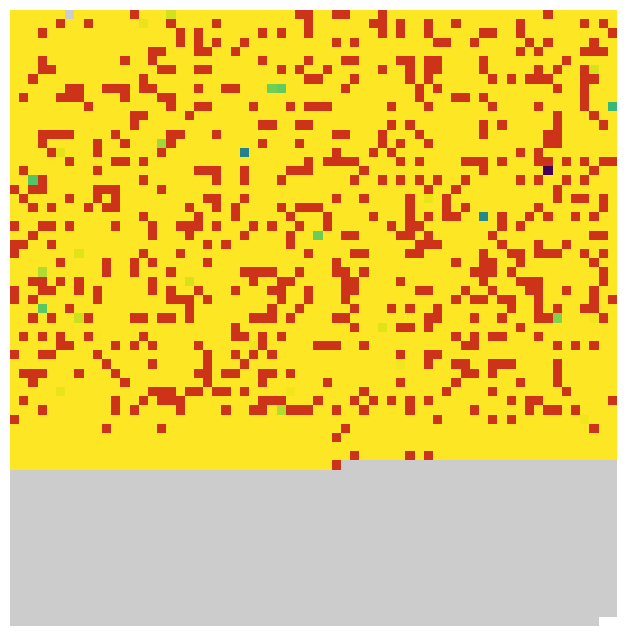

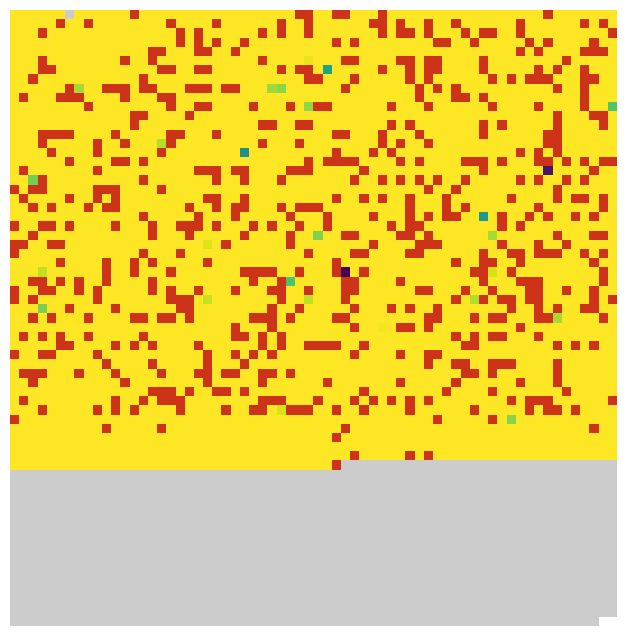

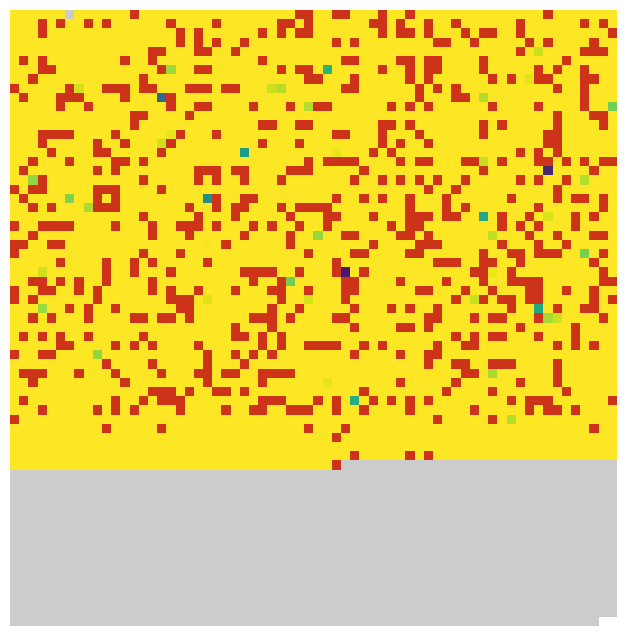

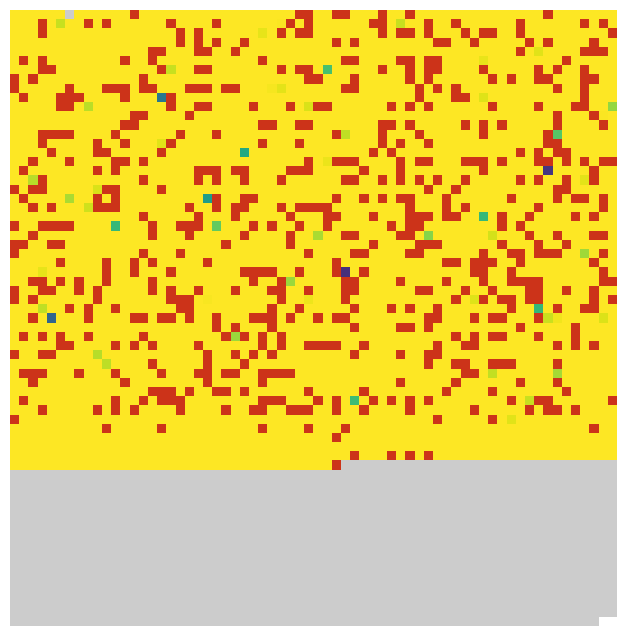

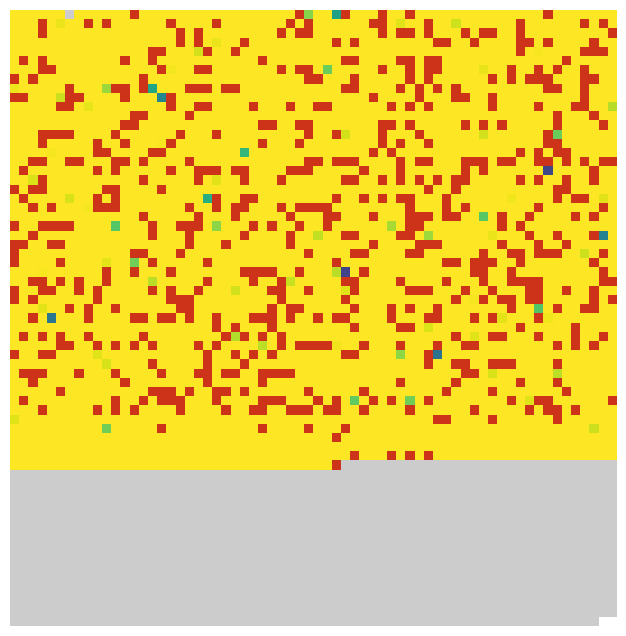

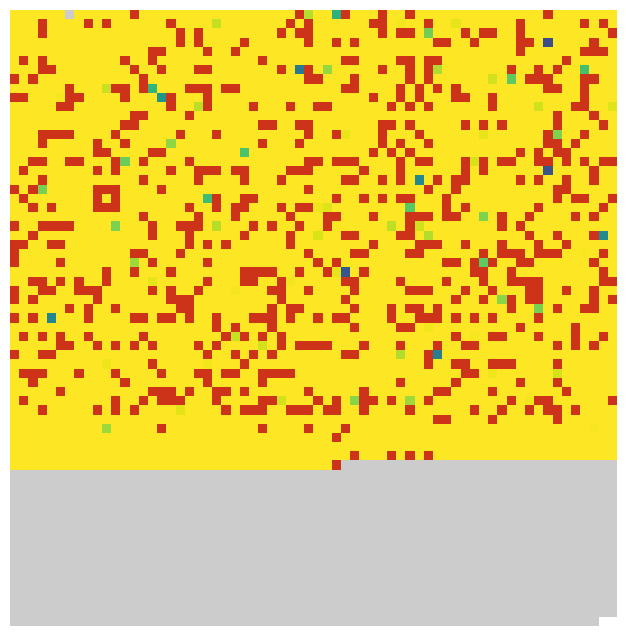

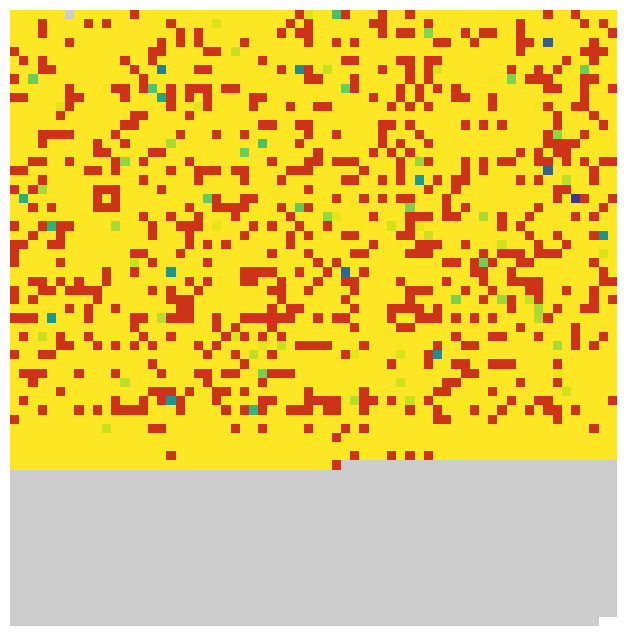

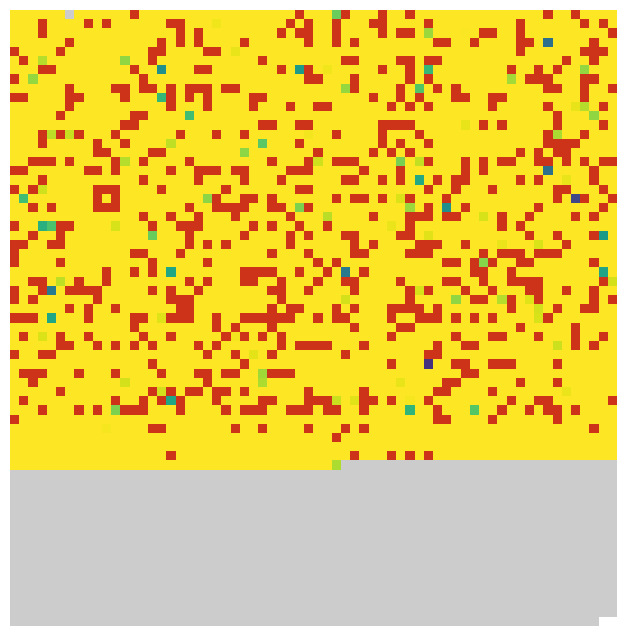

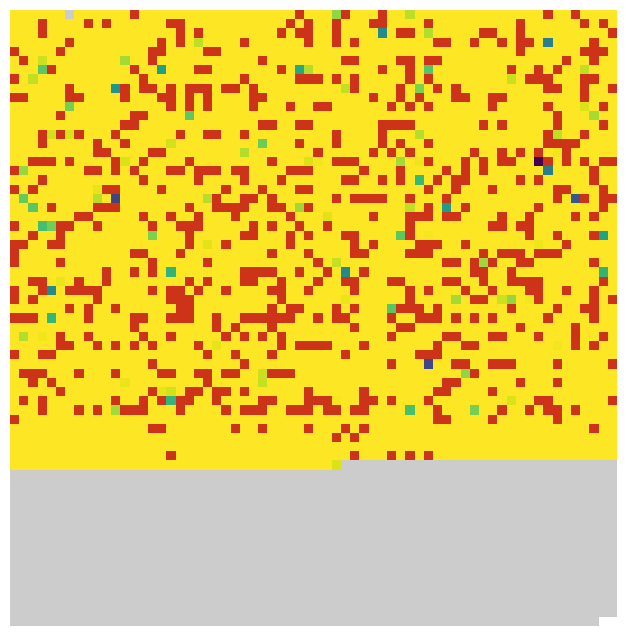

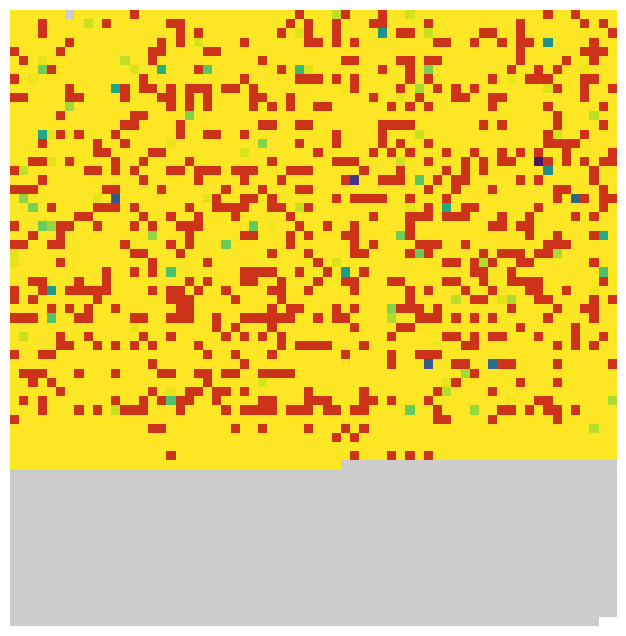

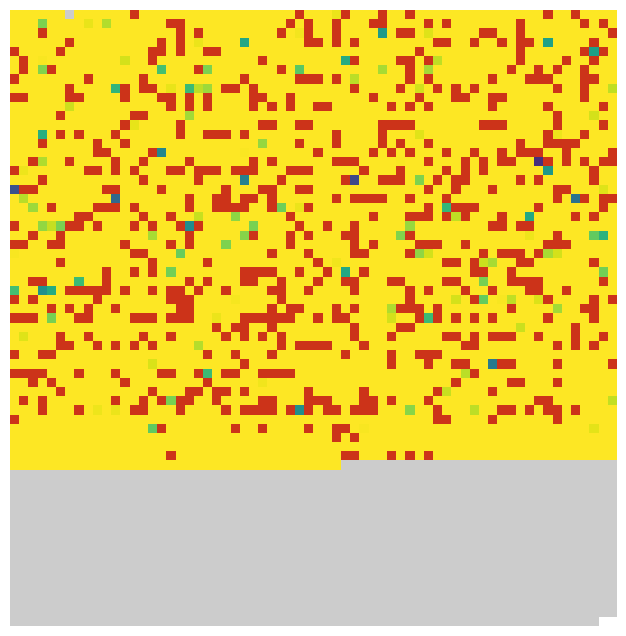

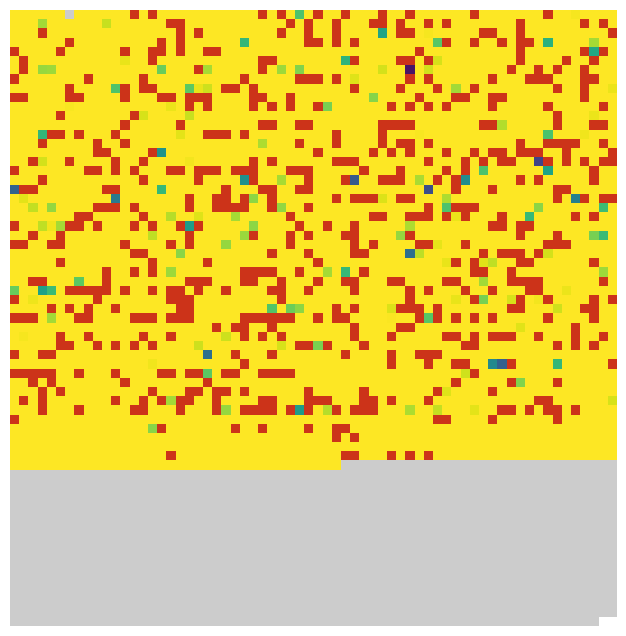

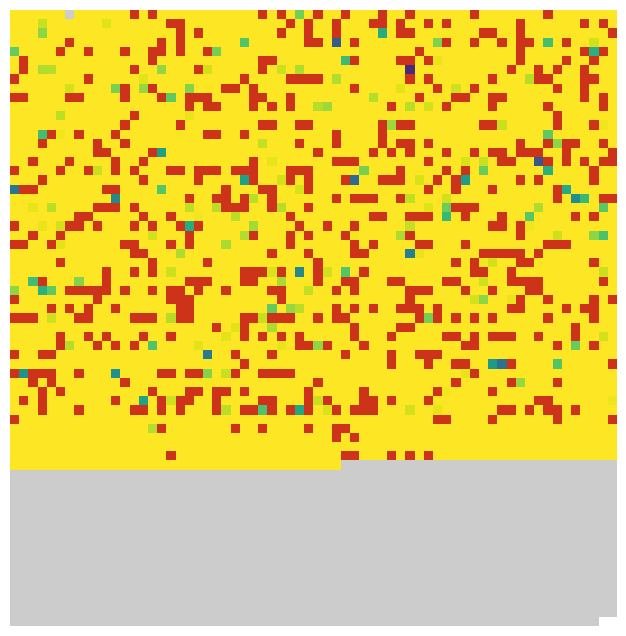

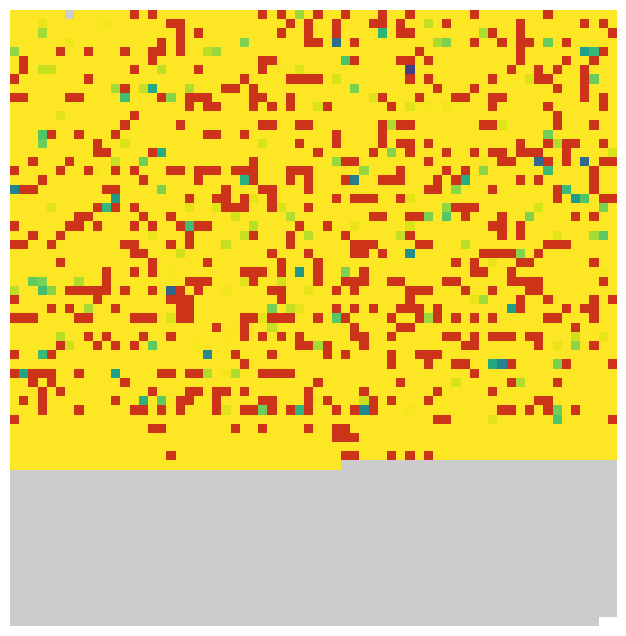

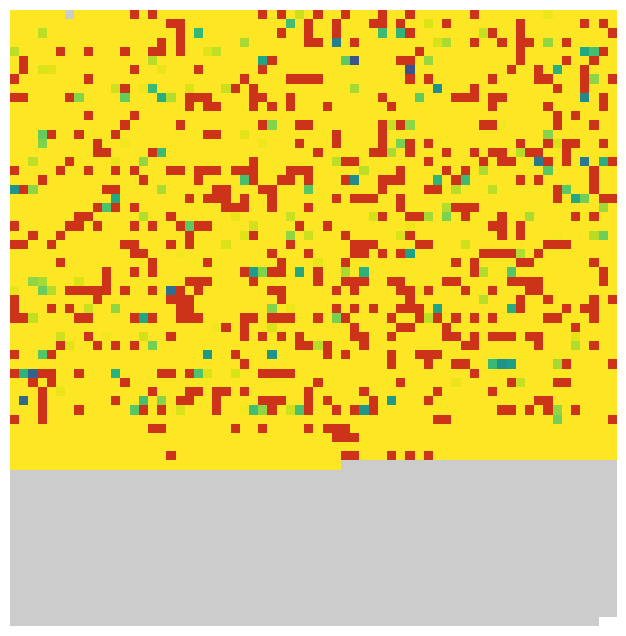

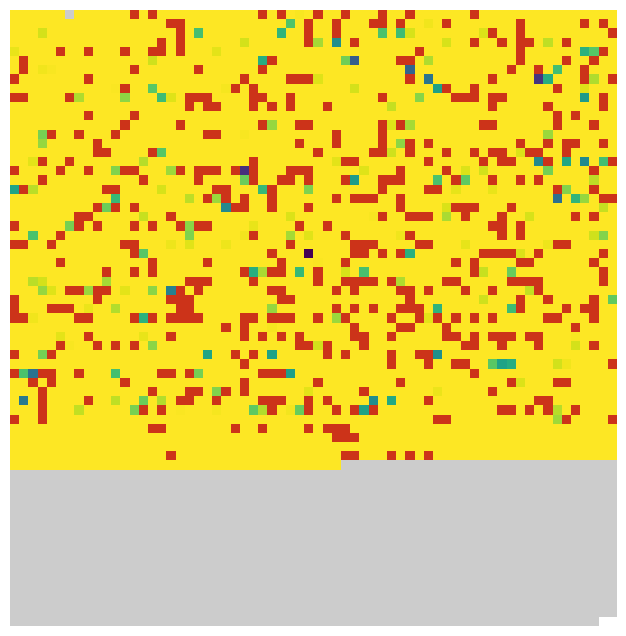

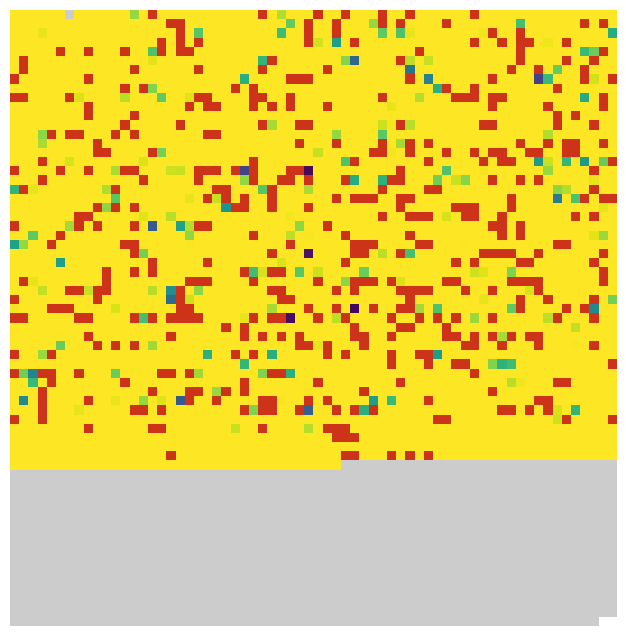

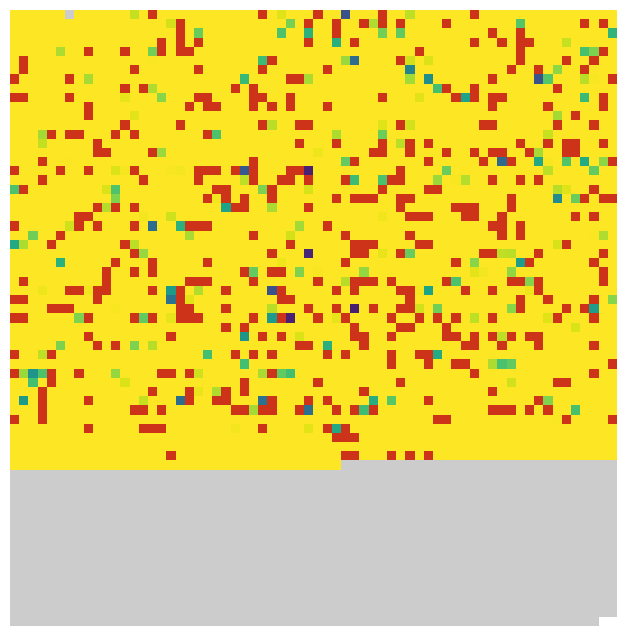

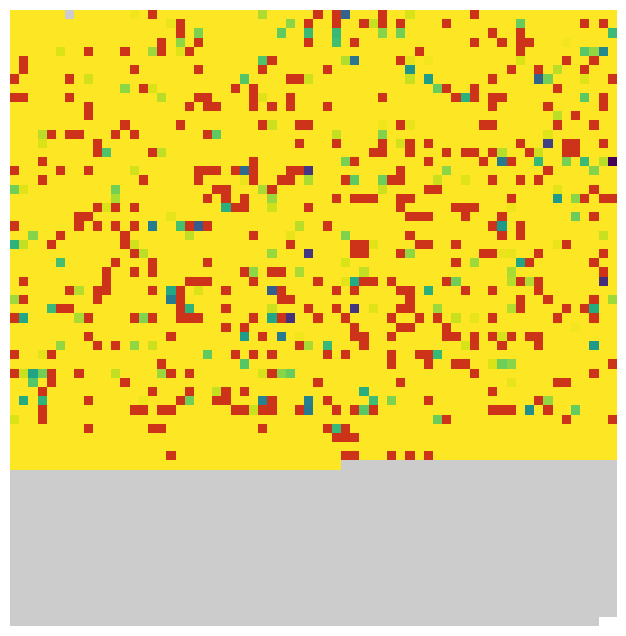

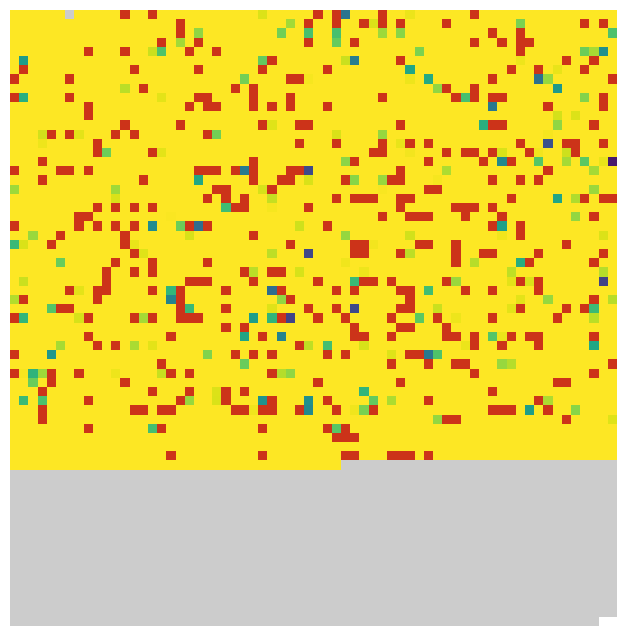

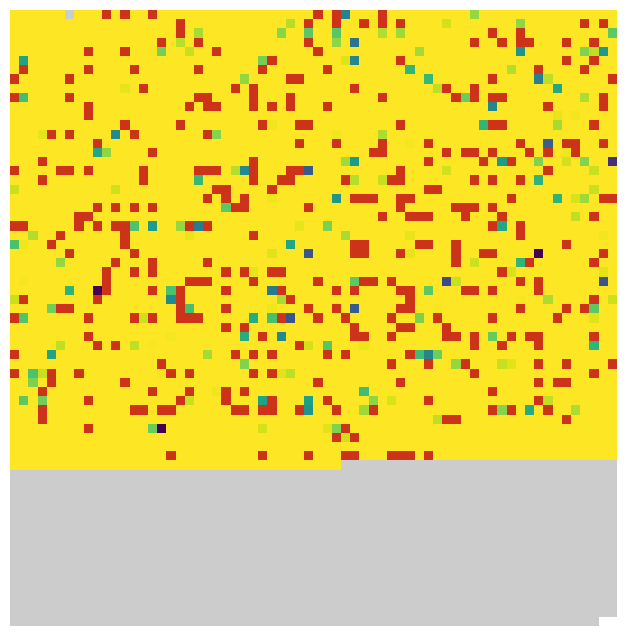

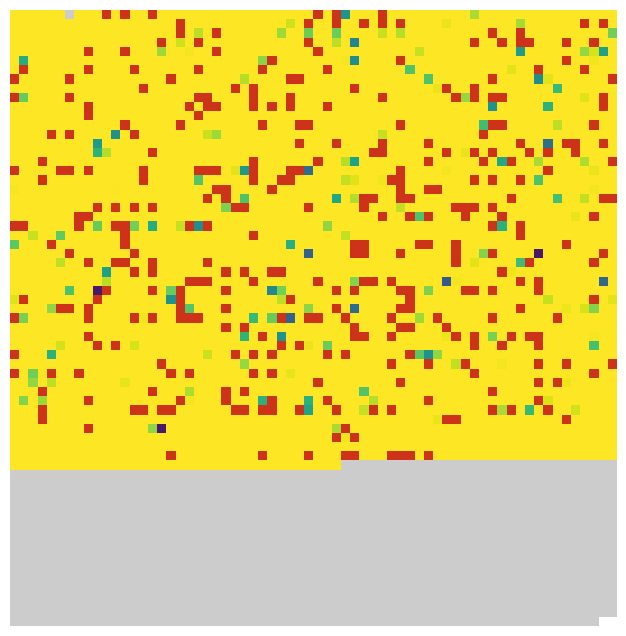

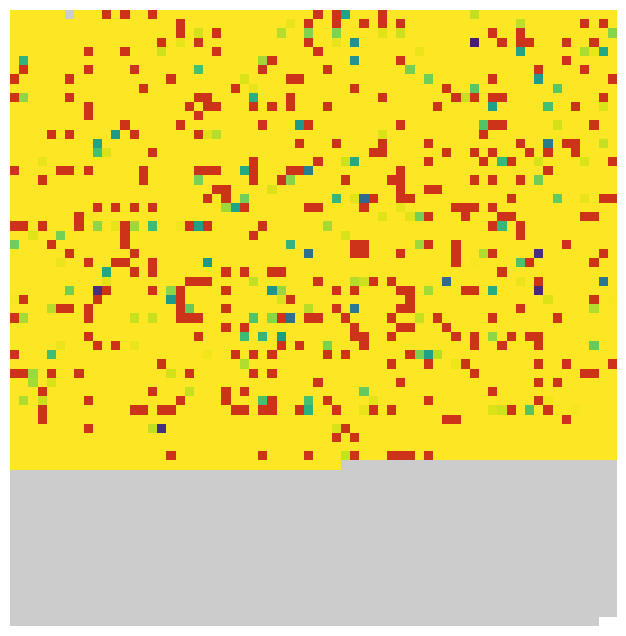

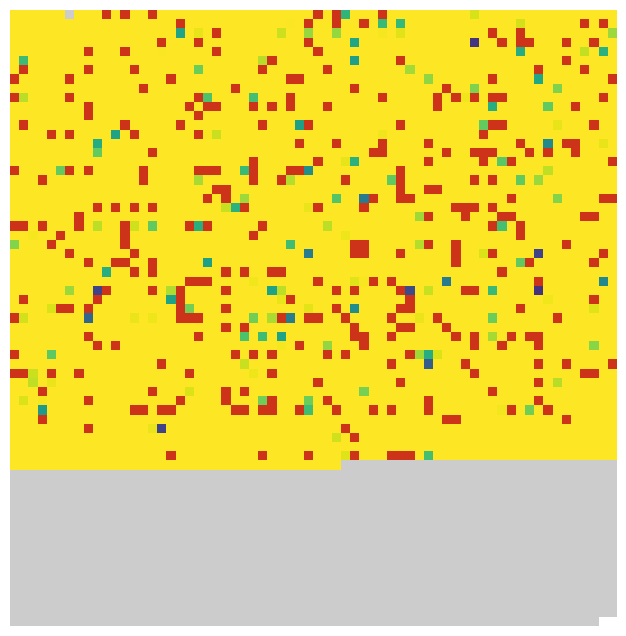

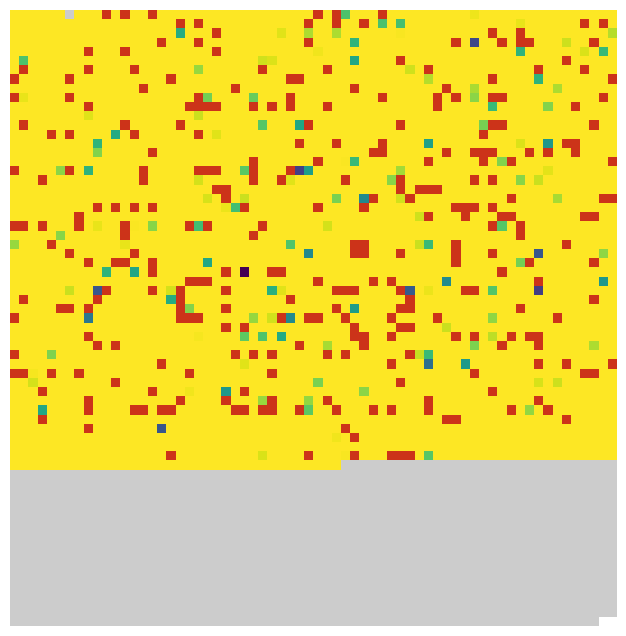

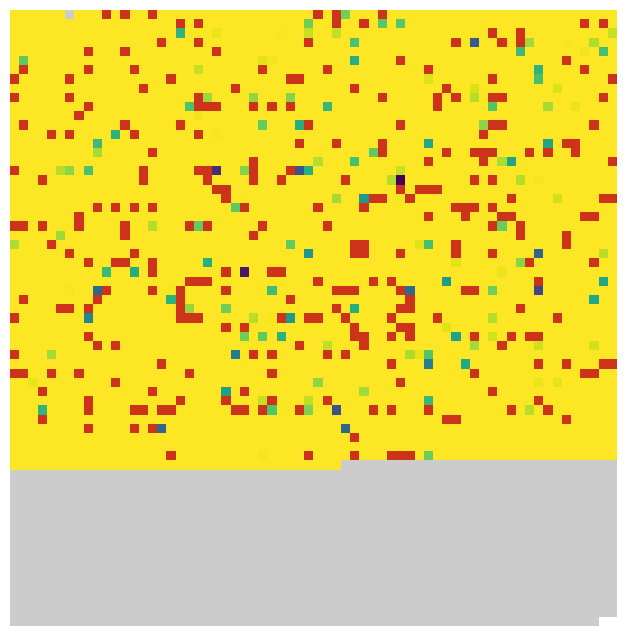

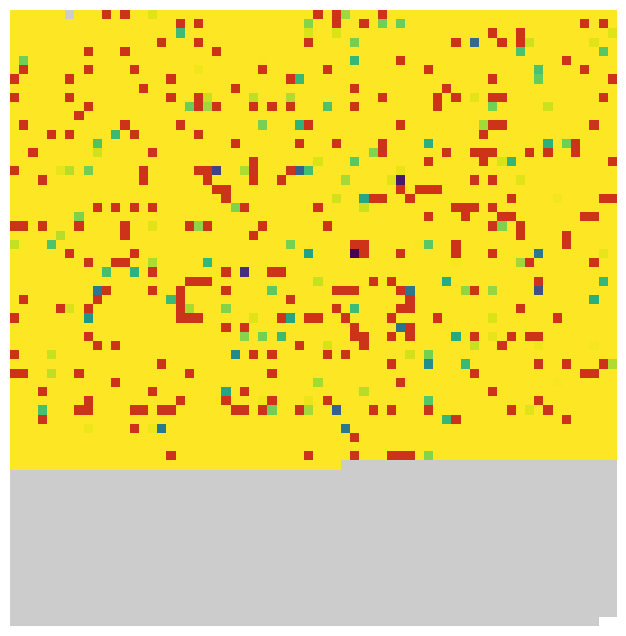

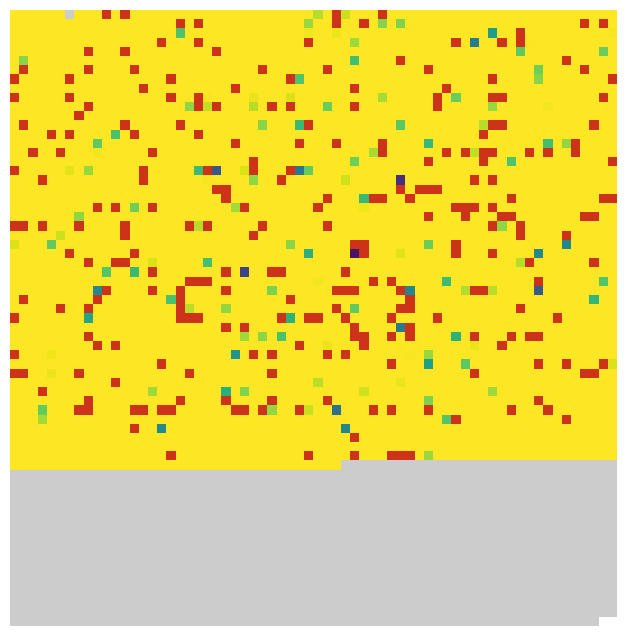

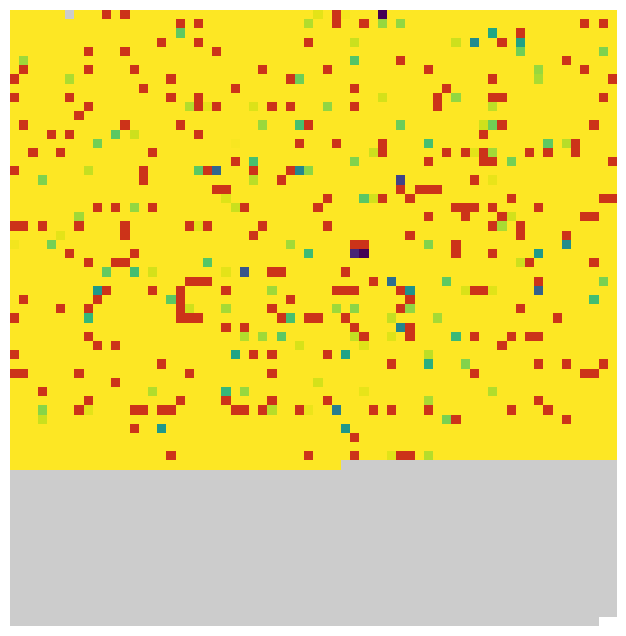

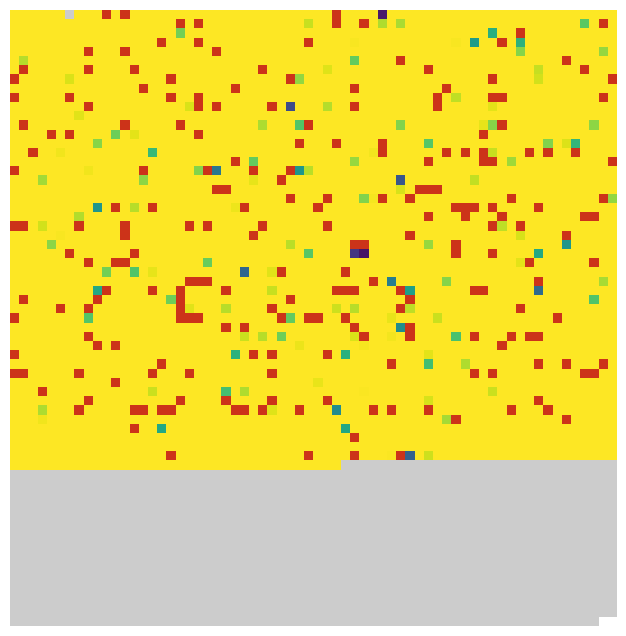

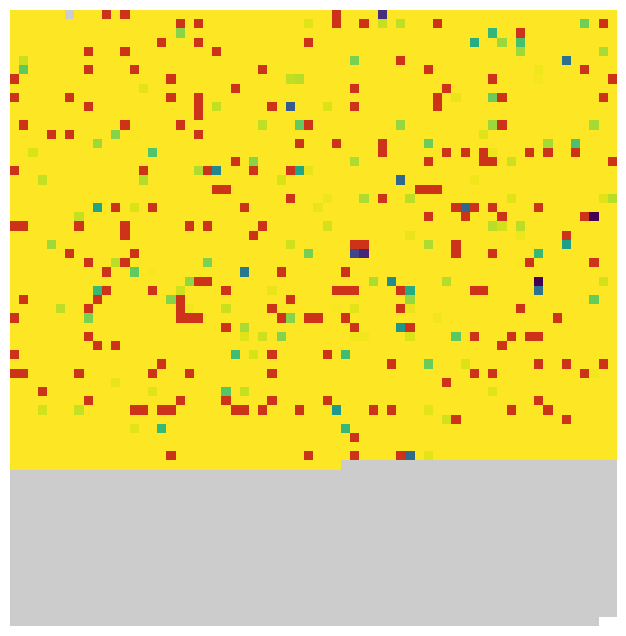

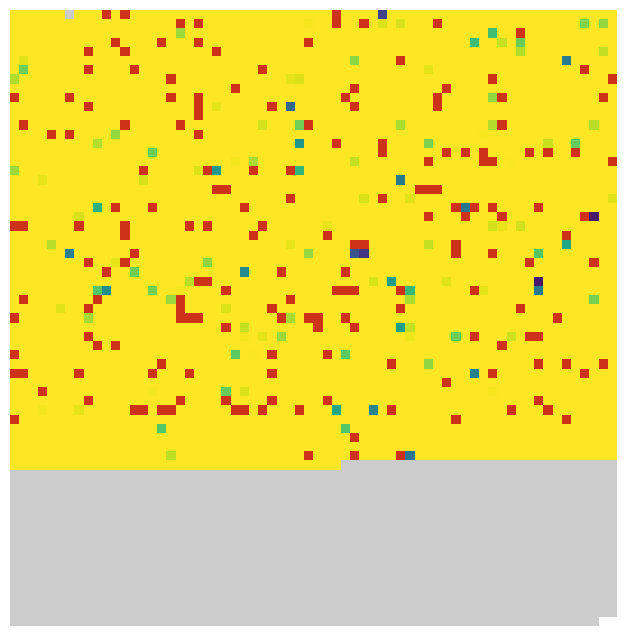

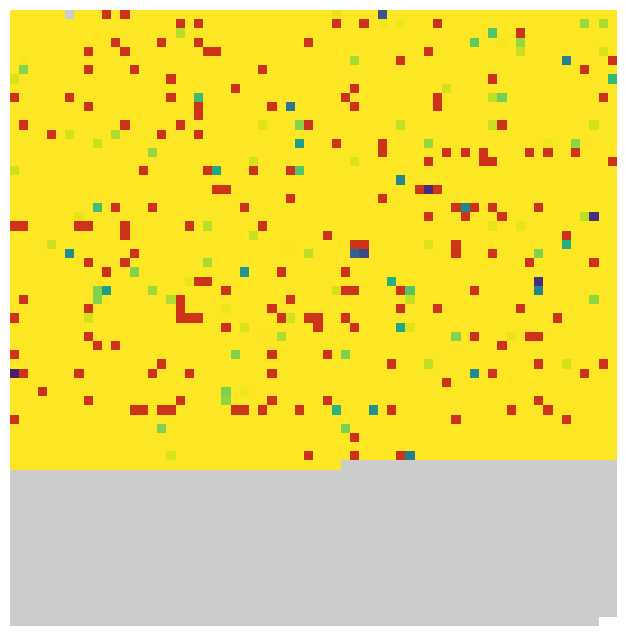

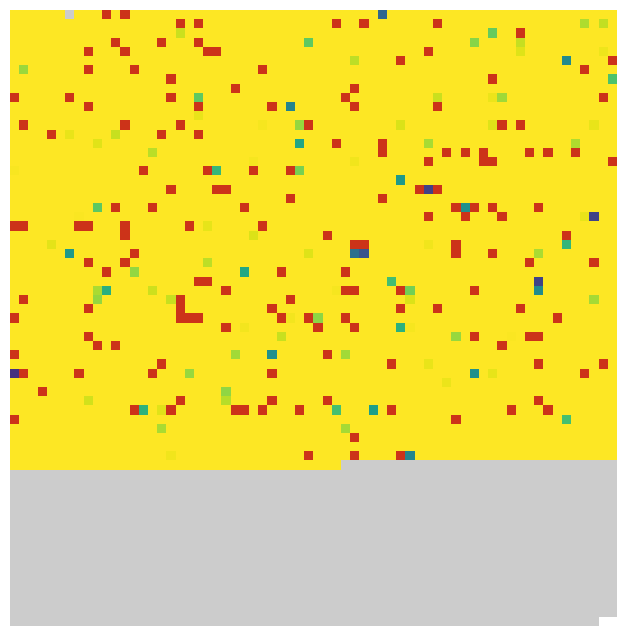

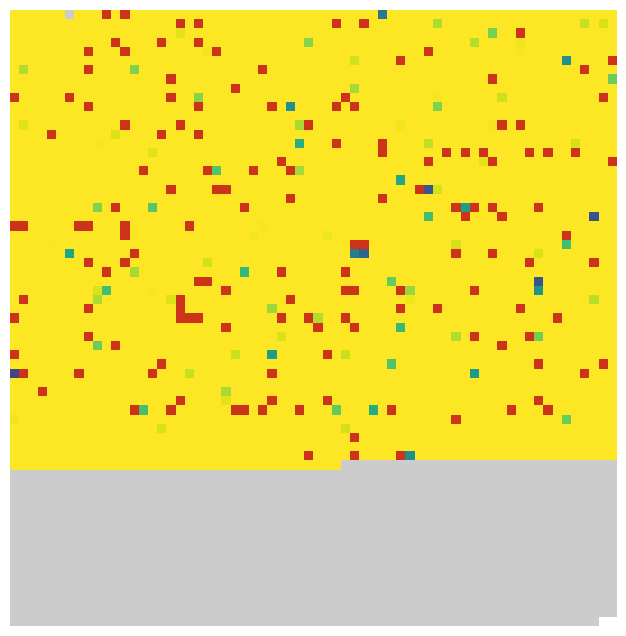

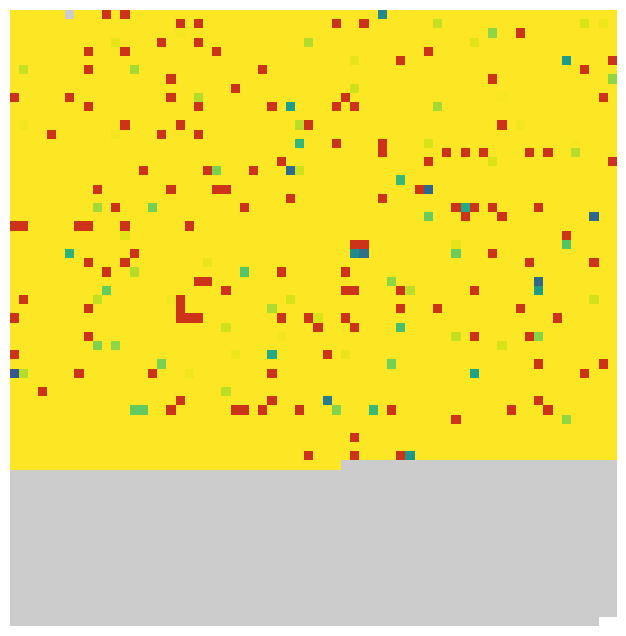

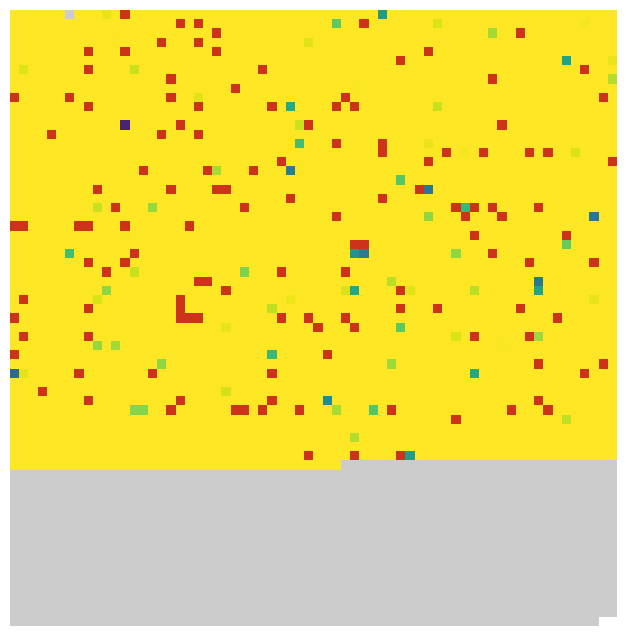

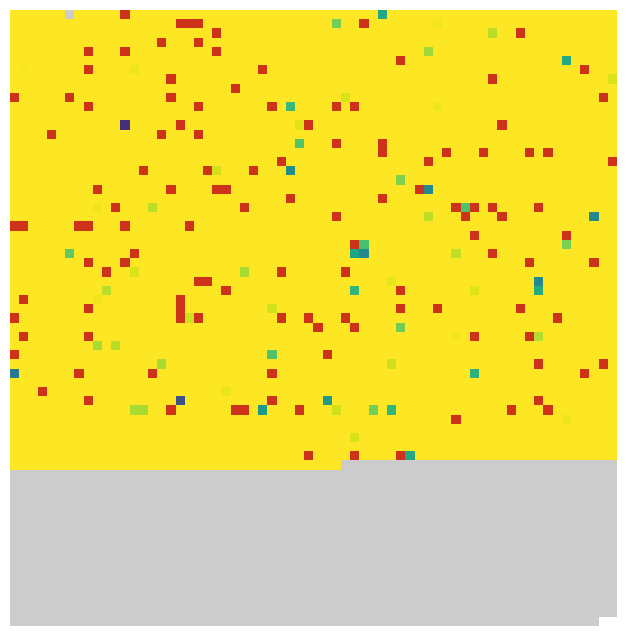

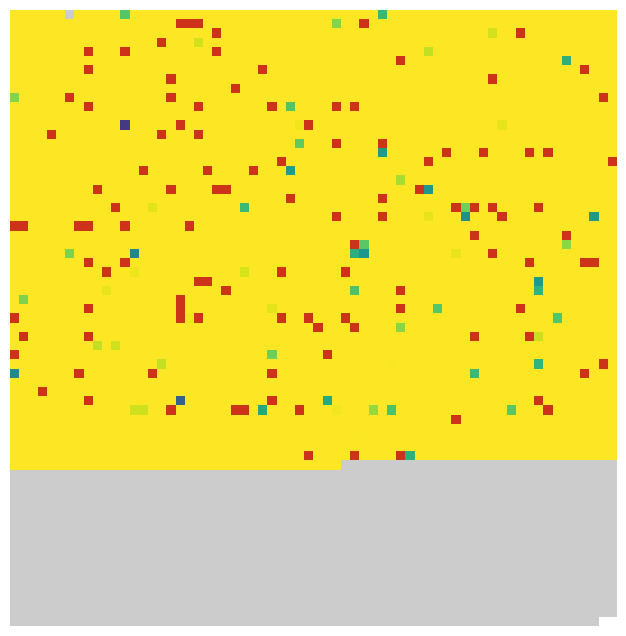

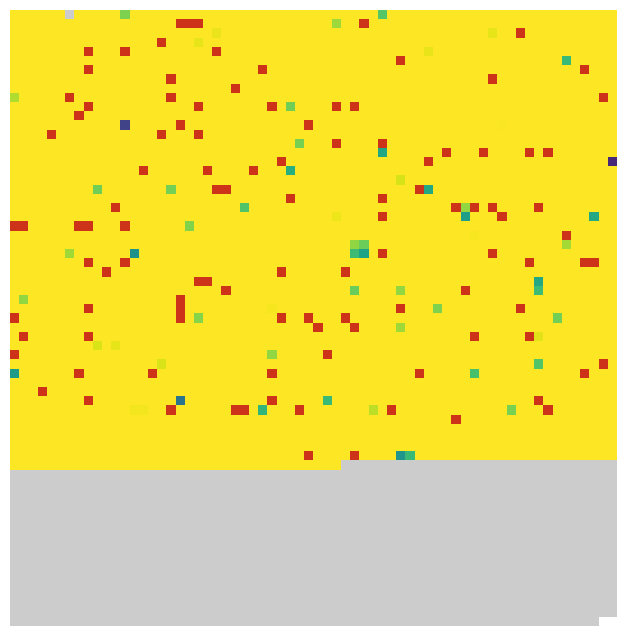

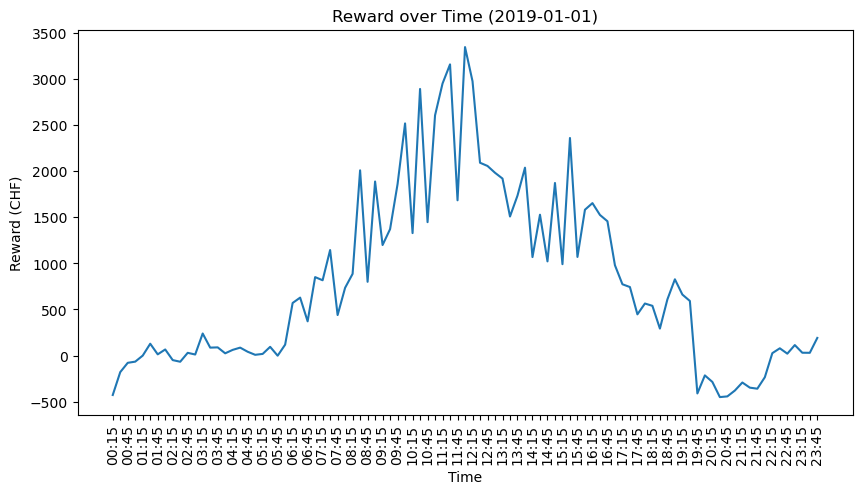

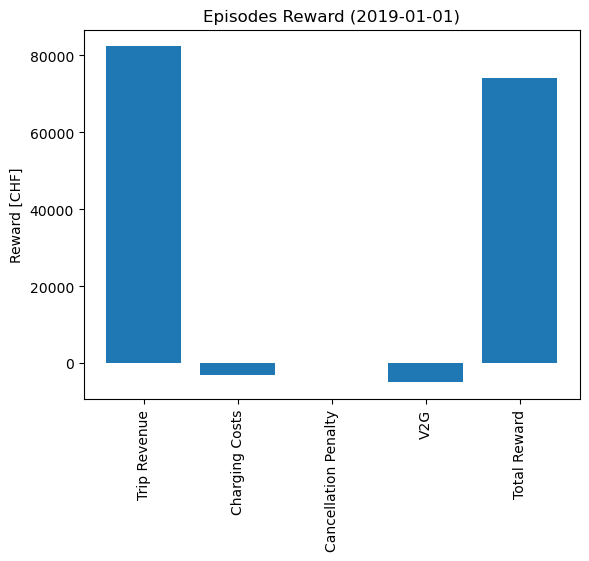

Total reward 2019-01-01:
74265.93785585415


In [13]:
# simulate one day
nr_iterations = 1

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length possible with available data
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    # load discrete planned reservation table
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    # load discrete planned reservation duration table
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # measure calculation time of episode
        start = time.time()
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        # reset environment at beginnning of simulation
        if count == 0:
            param_dict["stations"] = stations
            param_dict["vehicle_information"] = vehicles
            param_dict["daily_data"] = daily_data
            param_dict["reservations"] = reservations
            param_dict["electricity_price"] = electricity_price
            param_dict["timesteps_since_start"] = timesteps_since_start
            param_dict["planned_reservations"] = planned_reservations_day
            param_dict["planned_durations"] = planned_durations_day
            param_dict["v2g_price"] = v2g_price
            env = CarsharingEnv(**param_dict)
            s = env.reset()
            
        # beginn new day without reseting environemnt 
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            # print reward at time step
            print("Reward in this step:", rew, " time: ", env.t)
            
            counter +=1
        
        # measure time needed for simulation of day
        end = time.time()
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        
        # plot summary statistics of episode (day)
        env.daily_summary_statistics()
        
        # count number of simulated days
        count += 1